# Decode trial type. Must have at least 5 trials of each trial type/outcome being comopared in order for animal to contribute to decoding analysis that particular comparison

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_trial_type_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=20, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #only analyze if have > 5 trials of each trial type
        if (np.shape(np.where(labels[ani]==classes[0]))[-1]>=5) and (np.shape(np.where(labels[ani]==classes[1]))[-1]>=5): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            min_trials1=np.sum(labels[ani]==classes[0])
            min_trials2=np.sum(labels[ani]==classes[1])
            min_trials=min(min_trials1,min_trials2)
            for l in classes:
                if l>=0:                    
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

def Not_Run(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    return not_run,sum(which_cells)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

def combine_patterns(patterns, labels, n_patterns=100, classes=[0, 1], labels_mask=None):
    labels_comb = np.r_[list(classes)*n_patterns]
    patterns_comb_train = []
    for i in xrange(n_patterns):
        for odor in classes:
            try:
                p = np.concatenate([patterns[ani][np.random.choice([w for w in np.where(labels[ani]==odor)[0]])]
                                for ani in patterns.keys()])
                patterns_comb_train.append(p)
            except:
                #print "no %s labels"%odor,
                continue
    return np.r_[patterns_comb_train], labels_comb

In [7]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [8]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [9]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [10]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=20, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [11]:
#expo_animals =
#pre_animals = 
#mid_animals = 
post_animals = 'dhpc40', 'dhpc40b' ,'dhpc37', 'dhpc39', 'dNAc3'
high_performing_animals = 'dhpc37','dhpc39','dNAc3'

In [12]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [13]:
sessions = 'expo','pre','mid','post'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14, 14, 6]


In [14]:
for tb in bins:
    for sess in sessions:
        try:
            exec("patterns_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

nope 05s expo
nope 05s pre
nope 05s mid
nope 1s expo
nope 1s pre
nope 1s mid
nope 15s expo
nope 15s pre
nope 15s mid
nope 2s expo
nope 2s pre
nope 2s mid


In [15]:
for sess in 'post',:
    for tb,i in zip(bins,range(len(bins))):
        #if tb == '05s':
        #    div=0.5
        #else:
        #    div=tb[:-1]
        ##print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
        for t in range(bin_ranges[i]):
            exec('patterns_%s_%s_%s = {}'%(tb,sess,t))
            for ani in eval('%s_animals'%sess):
                try:
                    print sess, tb, ani,
                    exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))
                except:
                    print 'NOPE ',sess, tb, ani
                    continue

post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05

In [16]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [17]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
classes=[5,6],[5,7],[6,7],[1,2],[1,3],[2,3],[1,5],[2,6],[3,7]
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for cl,comp in zip(classes,comparisons):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('scores_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
            for sess in 'post',:
                print sess,t,comp[0],comp[1],
                try:
                    eval("scores_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("labels_%s"%sess),classes=cl, n_cells=None, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
    try:
        exec("not_run,total_cells_%s_vs_%s = Not_Run(patterns_%s_%s_%s,labels_%s,classes=cl, n_cells=None,\
              relabel=None)"%(comp[0],comp[1],tb,sess,t,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run
        print "total cells =",eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"

    #exec("total_%s_vs_%s_trials_post = 0"%(comp[0],comp[1]))
    for key in labels_post.keys():
        v0=0
        v1=0
        for val in labels_post[key]:
            if val == cl[0]:
                v0 += 1
            if val == cl[1]:
                v1 += 1
        print v0,v1
        exec("vals_%s = min(v0,v1)"%key)
        print "animal %s="%key,eval("vals_%s"%key),"min trials"
    sum_vals=0
    for key in labels_post.keys():
        if eval("vals_%s"%key)>=5:
            sum_vals = sum_vals + eval("vals_%s"%key)
    exec("total_%s_vs_%s_trials_post = sum_vals"%(comp[0],comp[1]))
    print "total_%s_vs_%s_trials_post ="%(comp[0],comp[1]),eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])),"\n"

post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run_CSm post 12 consumed run_CSm post 13 consumed run_CSm post 14 consumed run_CSm post 15 consumed run_CSm post 16 consumed run_CSm post 17 consumed run_CSm post 18 consumed run_CSm post 19 consumed run_CSm post 20 consumed run_CSm post 21 consumed run_CSm post 22 consumed run_CSm post 23 consumed run_CSm post 24 consumed run_CSm post 25 consumed run_CSm post 26 consumed run_CSm post 27 consumed run_CSm post 28 consumed run_CSm post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run

In [18]:
dark_co = ('forestgreen','darkcyan','firebrick')

In [19]:
bin_ranges

[29, 14, 14, 6]

In [20]:
#comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
#['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']

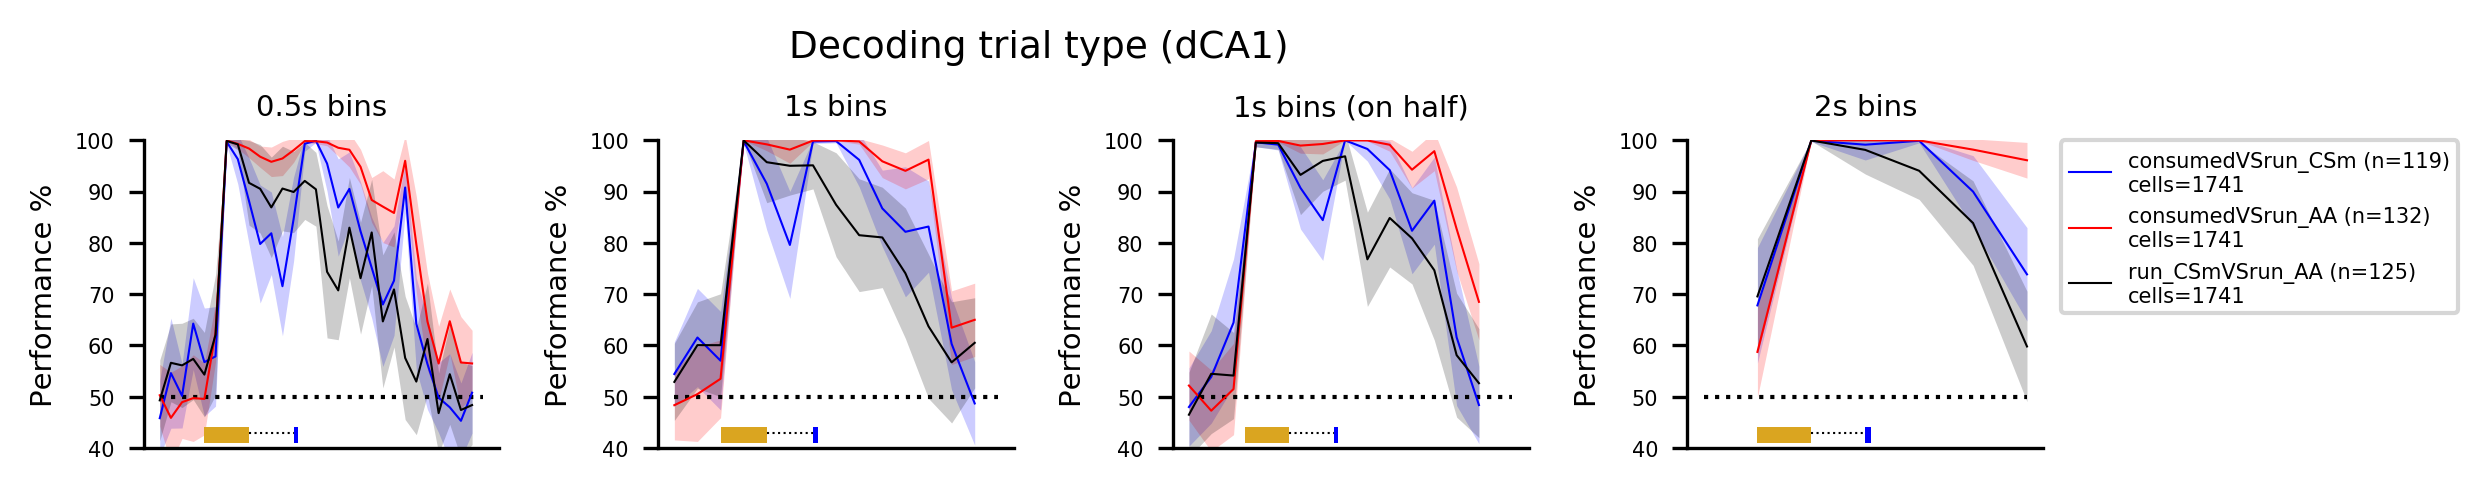

In [21]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[:3],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                   label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
        m = np.array([(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
        s = np.array([np.std(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
        ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun.jpg'%NOTEBOOK_NAME)

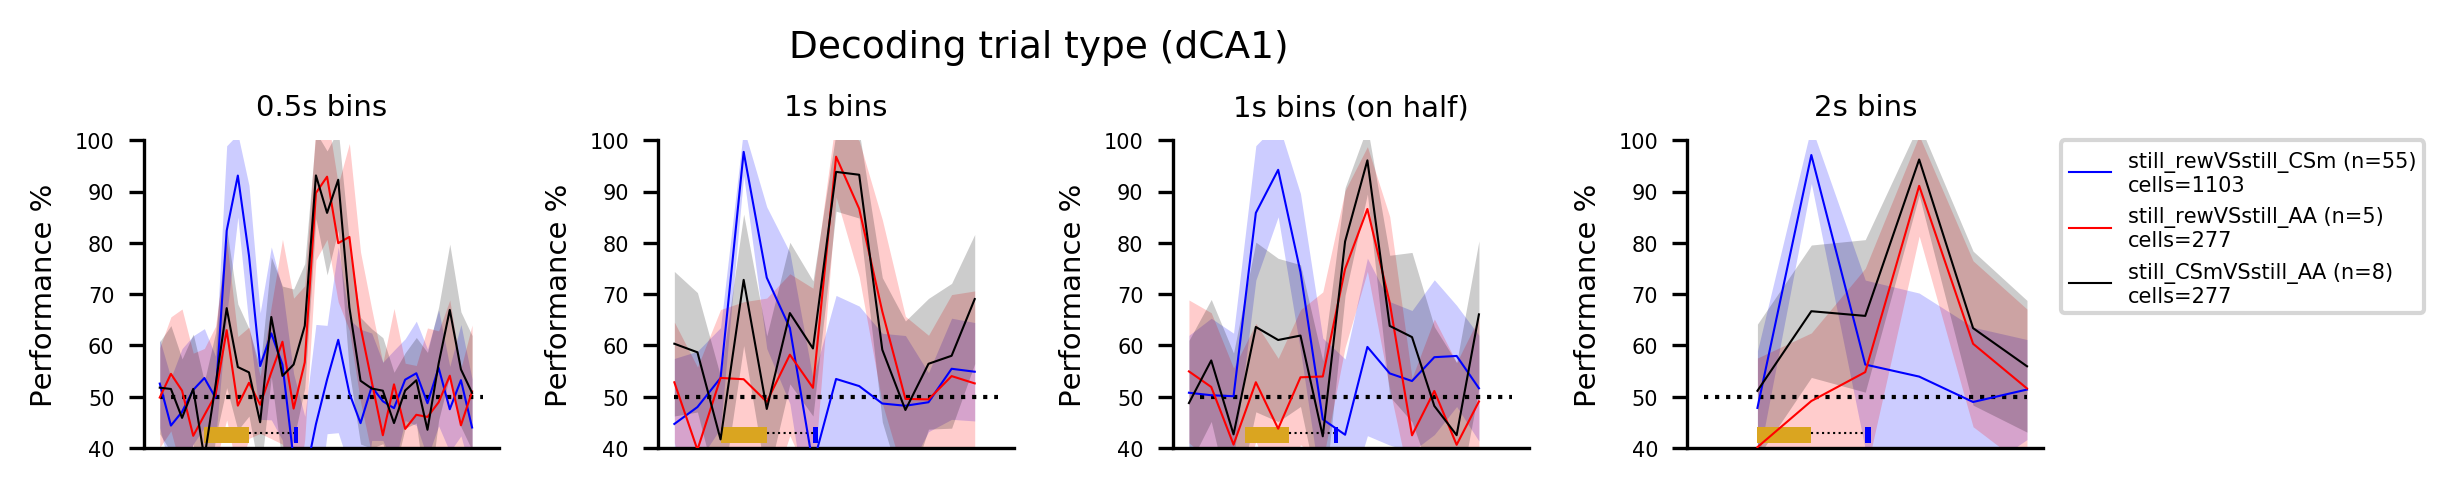

In [22]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[3:6],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                   label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
        m = np.array([(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
        s = np.array([np.std(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
        ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSstill.jpg'%NOTEBOOK_NAME)

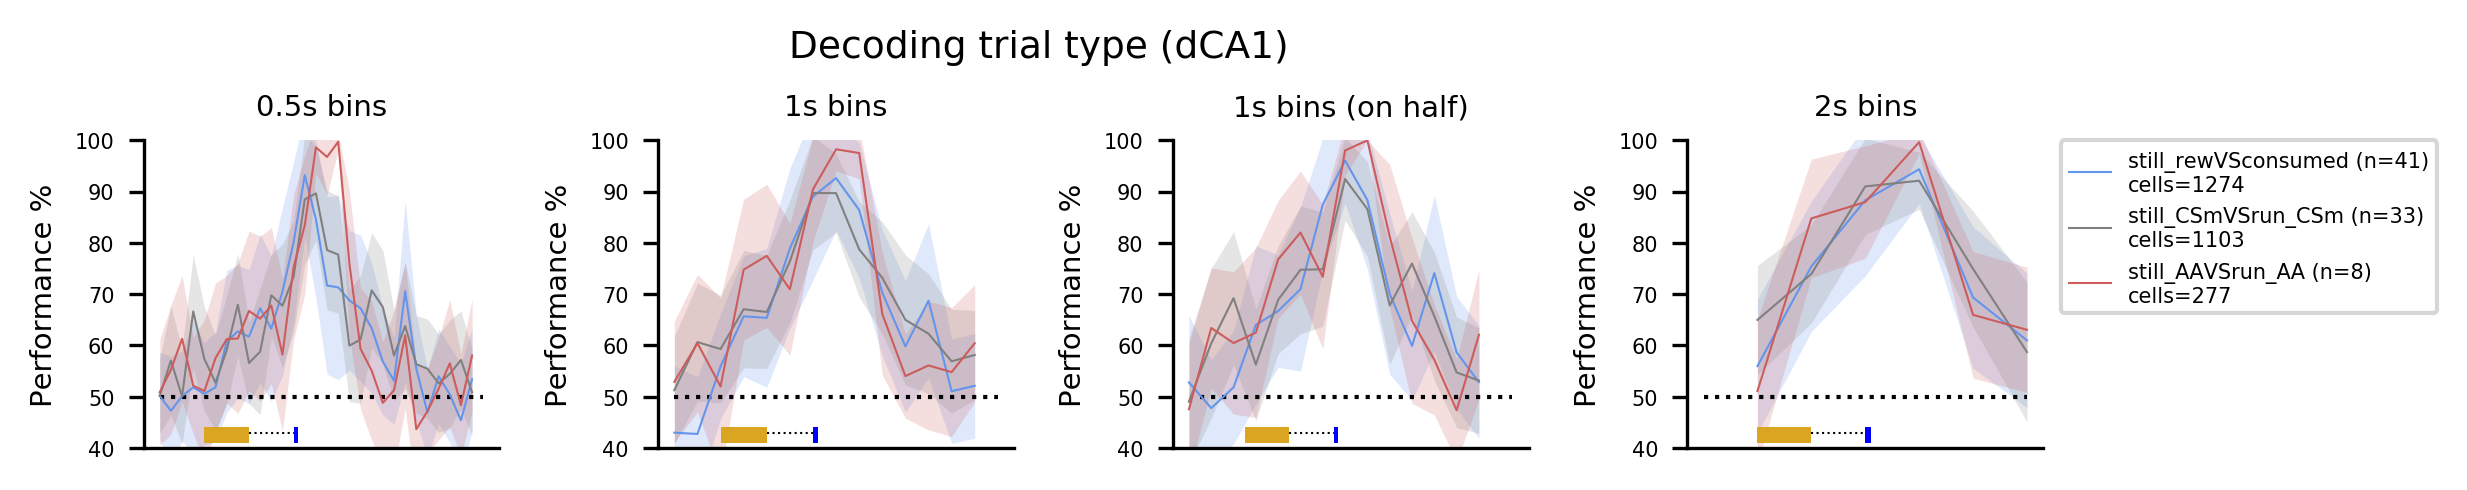

In [23]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[6:],['cornflowerblue','grey','indianred']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                   label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSrun.jpg'%NOTEBOOK_NAME)

# now decode each animal individually

In [24]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [25]:
%%time
## use this from the decoding_around_onset nb (for a single animal) as a guide
from sklearn.svm import LinearSVC
decodor = LinearSVC()
from sklearn.model_selection import cross_val_score, LeaveOneOut

classes=[5,6],[5,7],[6,7],[1,2],[1,3],[2,3],[1,5],[2,6],[3,7]
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for cl,comp in zip(classes,comparisons):
    left_out=[]
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            for sess in 'post',:
                exec("individ_scores_%s_vs_%s_%s_%s_%s = {}"%(comp[0],comp[1],tb,sess,t))
                for ani in eval("patterns_%s_%s_%s.keys()"%(tb,sess,t)):
                    #try:
                        if (np.shape(np.where(eval("labels_%s[ani]"%sess)==cl[0]))[-1]>=5) and (np.shape(np.where(eval("labels_%s[ani]"%sess)==cl[1]))[-1]>=5):
                            eval("individ_scores_%s_vs_%s_%s_%s_%s"%(comp[0],comp[1],tb,sess,t))[ani]=[]
                            #now find min # of trials for each trial type being compared, and then take random subset of trials of this min# of trials
                            exec("num_trials = (np.sum(labels_%s[ani]==cl[0]), np.sum(labels_%s[ani]==cl[1]))"%(sess,sess))
                            min_trials=min(num_trials)
                            print num_trials,min_trials,
                            exec("which_trials = (labels_%s[ani]==cl[0], labels_%s[ani]==cl[1])"%(sess,sess)) # make 2 arrays
                            #wt = np.random.permutation(np.where(labels[ani]==l)[0][:10])
                            exec("patterns0=np.random.permutation(patterns_%s_%s_%s[ani][which_trials[0]])"%(tb,sess,t))
                            exec("patterns1=np.random.permutation(patterns_%s_%s_%s[ani][which_trials[1]])"%(tb,sess,t))
                            patterns0=patterns0[:min_trials]
                            patterns1=patterns1[:min_trials]
                            min_patterns = list(patterns0) + list(patterns1)
                            #below is a round about way of getting min_trial # of entries for each label. I'm sure a much more efficient way of doing this, but can't be bothered atm
                            exec("labels0=labels_%s[ani][which_trials[0]][:min_trials]"%(sess))
                            exec("labels1=labels_%s[ani][which_trials[1]][:min_trials]"%(sess))
                            min_labels=list(labels0) + list(labels1)
                            print len(min_patterns),len(min_labels),
                            eval("individ_scores_%s_vs_%s_%s_%s_%s"%(comp[0],comp[1],tb,sess,t))[ani] = np.r_[[(cross_val_score(decodor,
                              min_patterns, min_labels,cv=LeaveOneOut()))]]
                            #print '%s_vs_%s_%s_%s_%s_%s Done'%(comp[0],comp[1],tb,sess,t,ani),
                        else:
                            left_out.append(ani)
                            #print '%s_vs_%s_%s_%s_%s_%s NOPE'%(comp[0],comp[1],tb,sess,t,ani)
    print 'Animals not included for %s_vs_%s: '%(comp[0],comp[1])+str(np.unique(left_out))

(34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72 72 (15, 13) 13 26 26 (15, 8) 8 16 16 (35, 28) 28 56 56 (34, 39) 34 68 68 (36, 38) 36 72

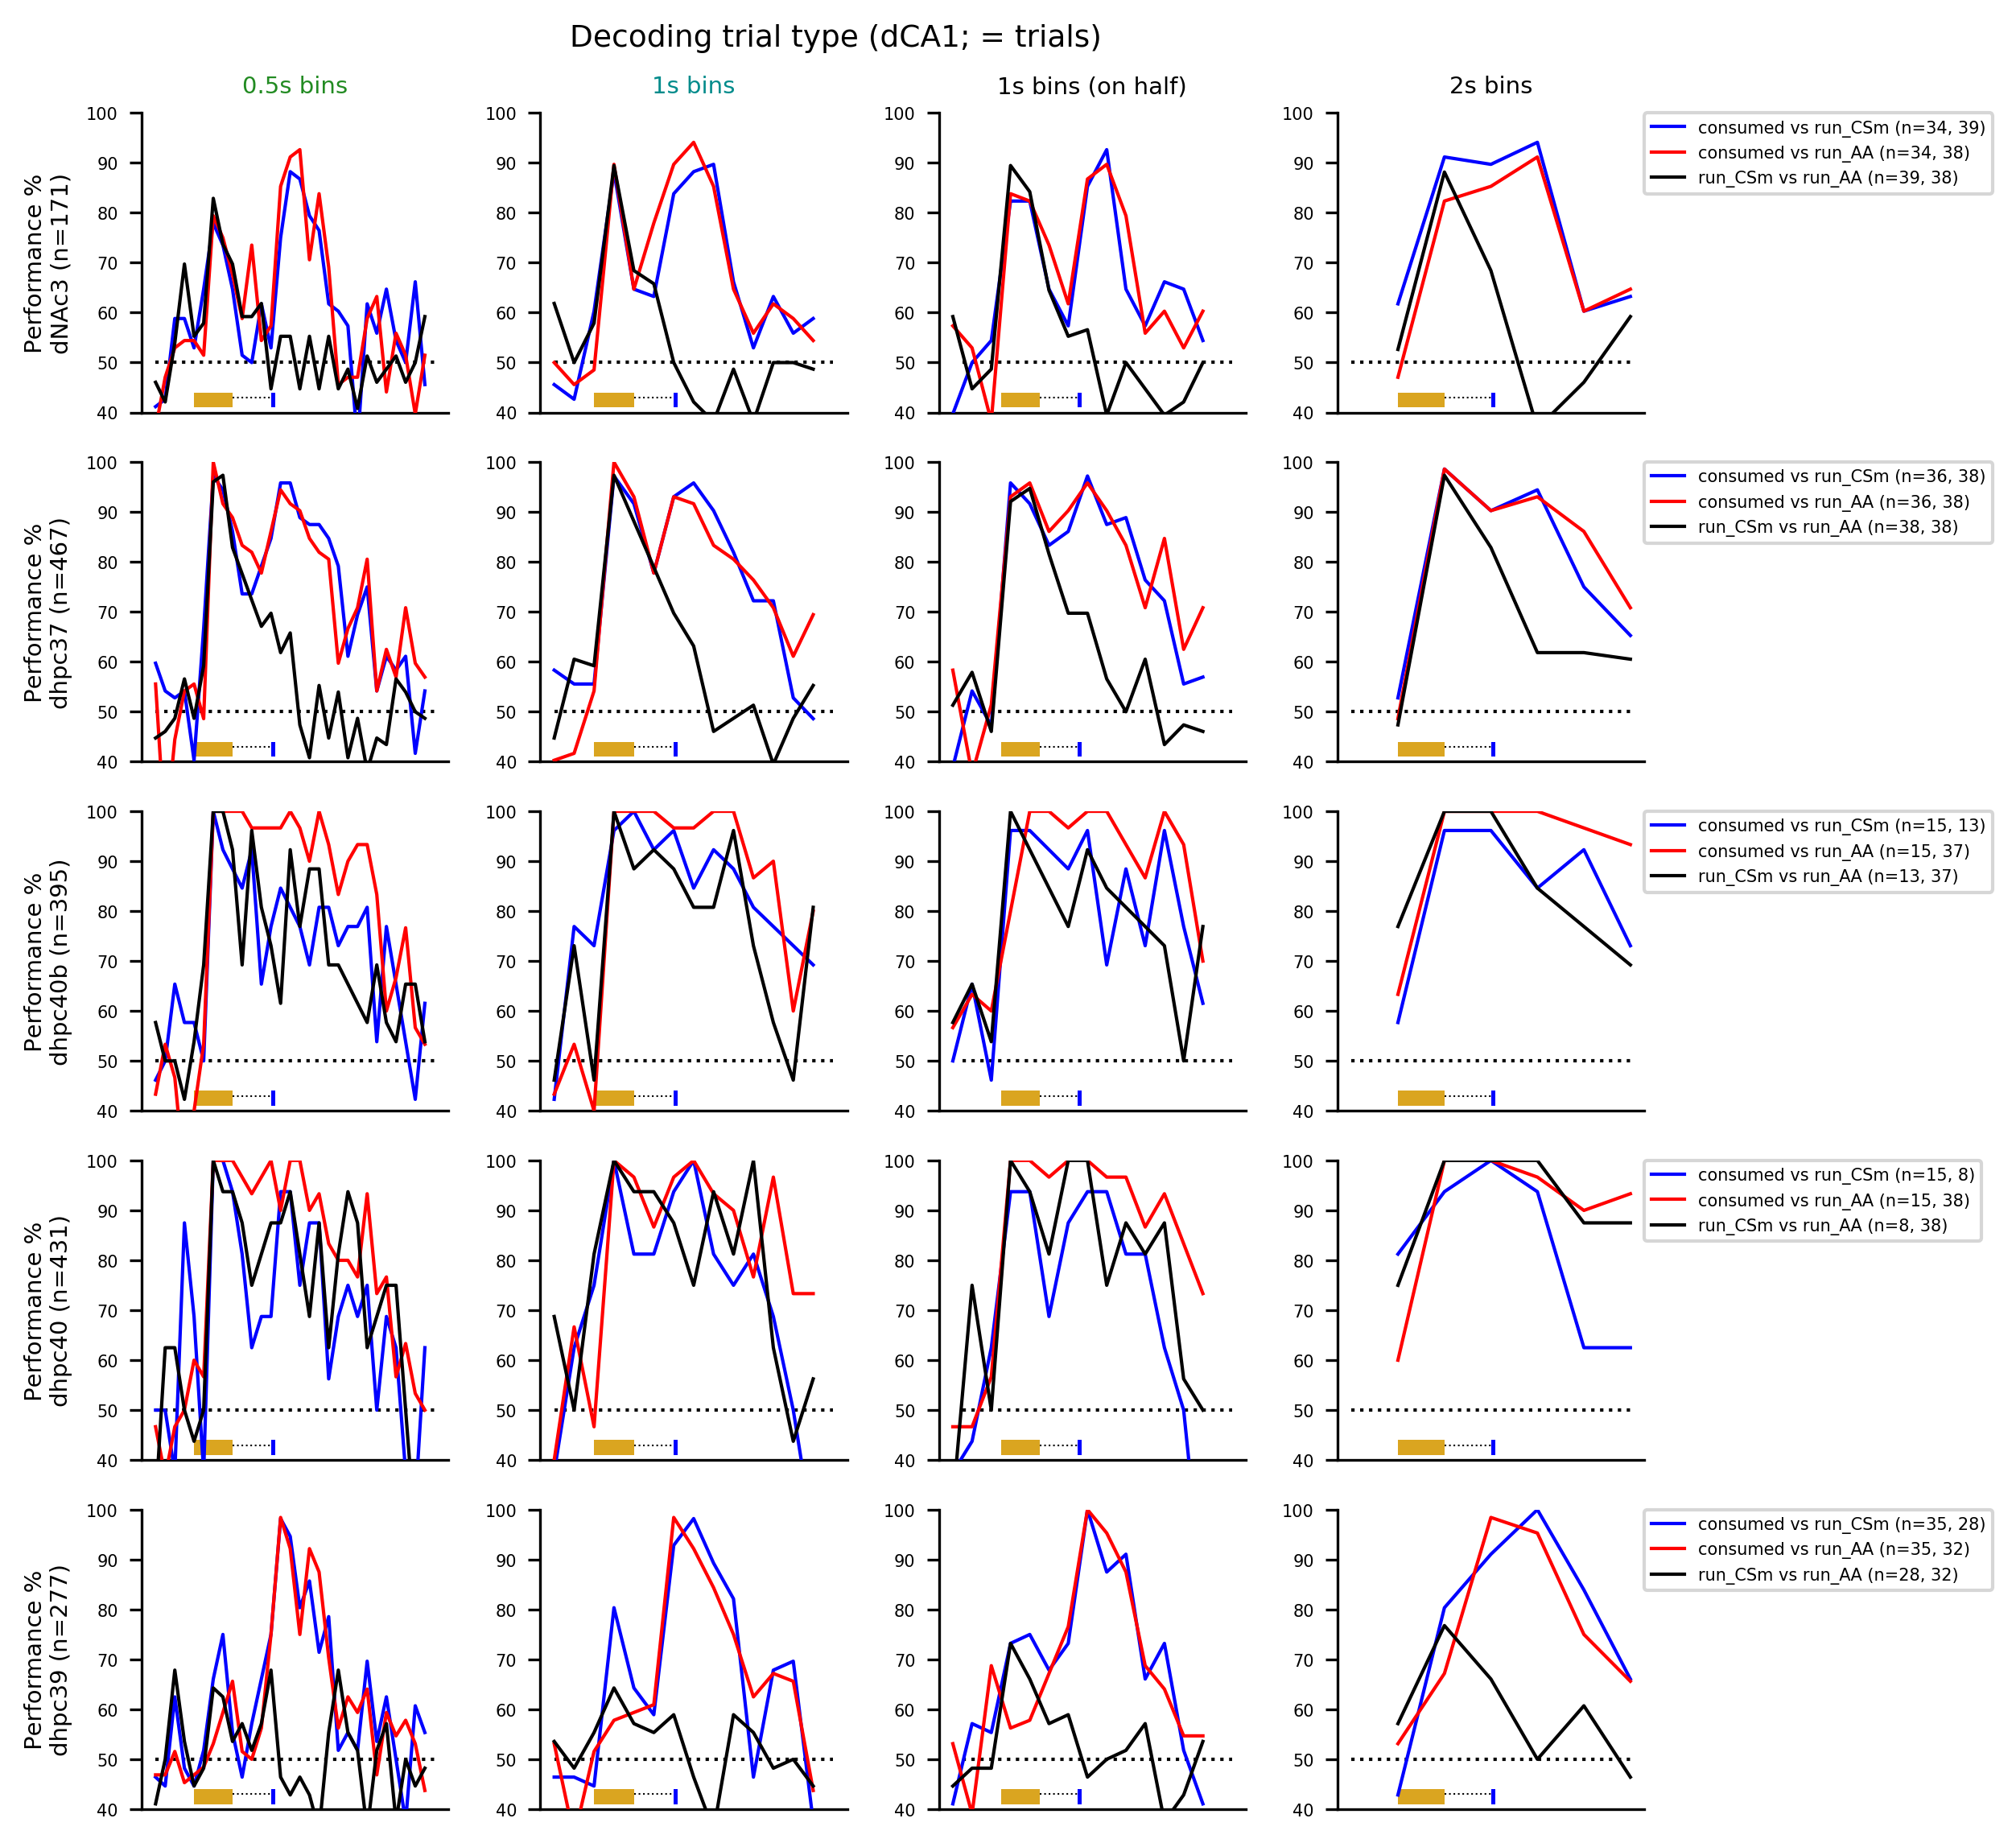

In [26]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))))

for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,cl in zip(comparisons[:3],['b','r','k'],classes[:3]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=1, zorder=19 ,ms=1,
                           label='%s vs %s (n='%(comp[0],comp[1])+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[0]))))+
                           ", "+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[1]))))+")")
                m = np.array([(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%svs_%s__%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))/(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                #ax[y][1].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half)')
ax[0][3].set_title('2s bins')
pl.suptitle("Decoding trial type (dCA1; = trials)", fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun_individ.jpg'%NOTEBOOK_NAME)

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


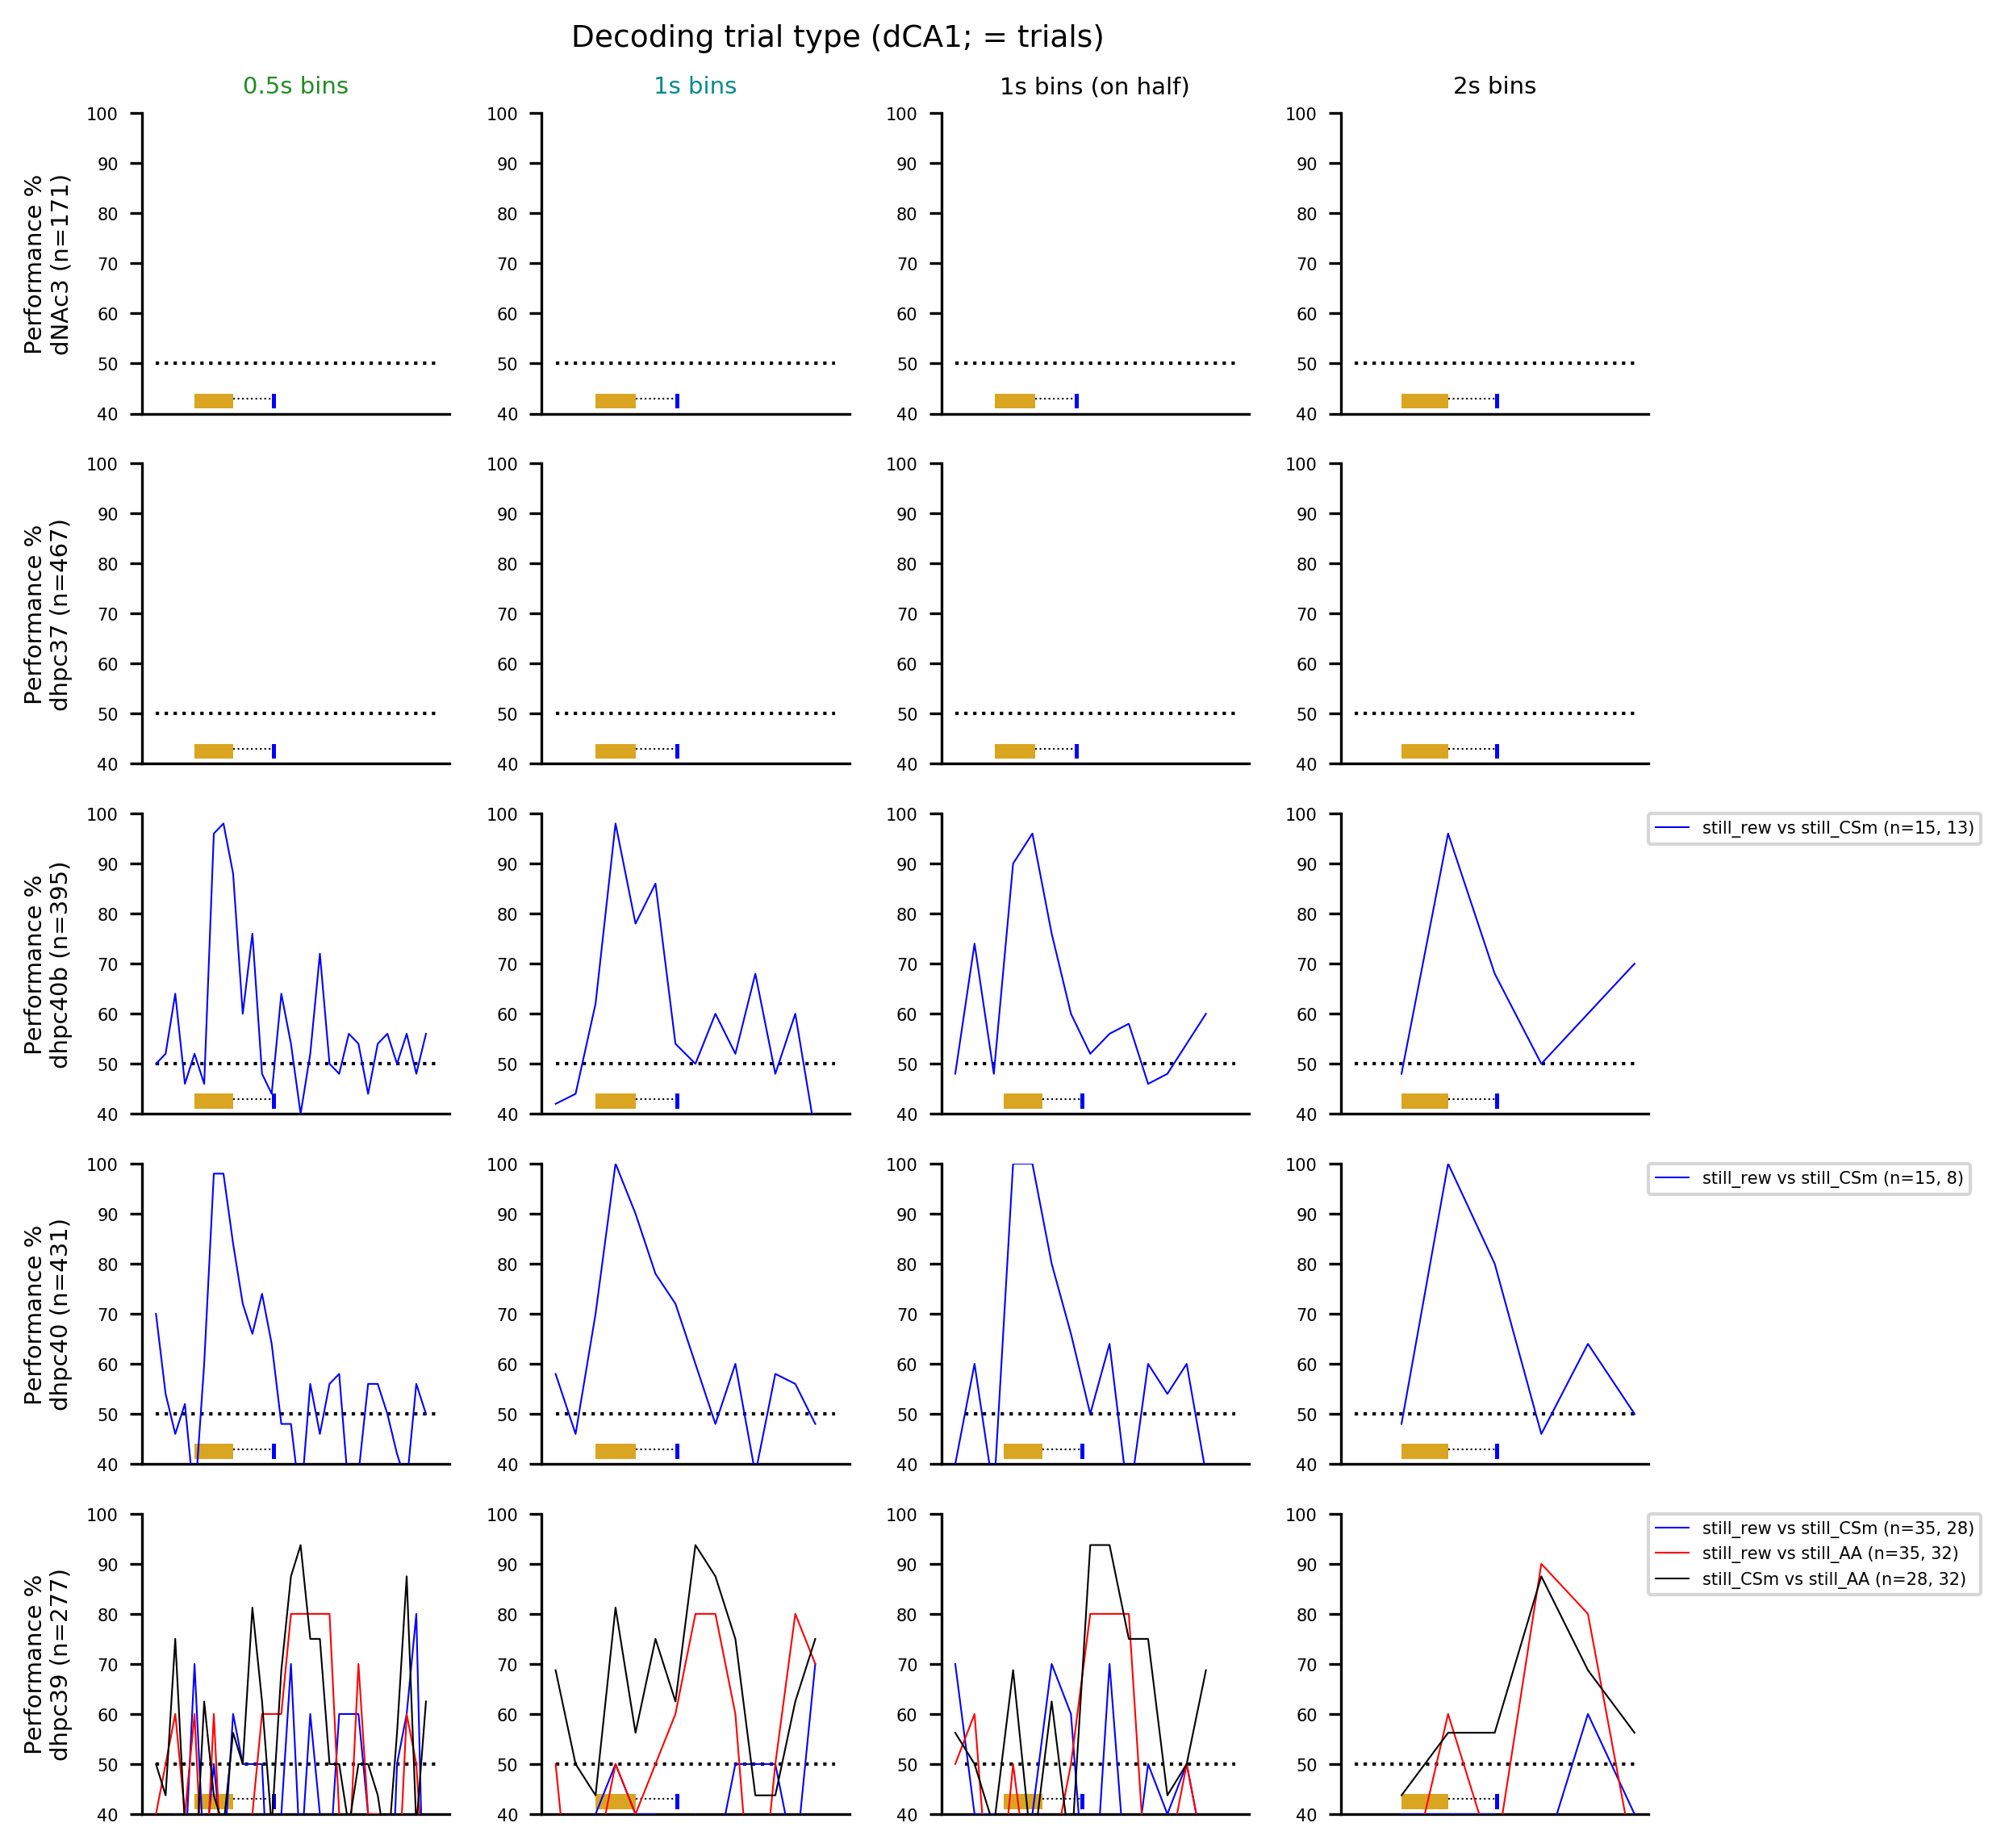

In [27]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))))

for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,cl in zip(comparisons[3:6],['b','r','k'],classes[:3]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                           label='%s vs %s (n='%(comp[0],comp[1])+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[0]))))+
                           ", "+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[1]))))+")")
                m = np.array([(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%svs_%s__%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))/(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                #ax[y][1].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half)')
ax[0][3].set_title('2s bins')
pl.suptitle("Decoding trial type (dCA1; = trials)", fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSstill_individ.jpg'%NOTEBOOK_NAME)

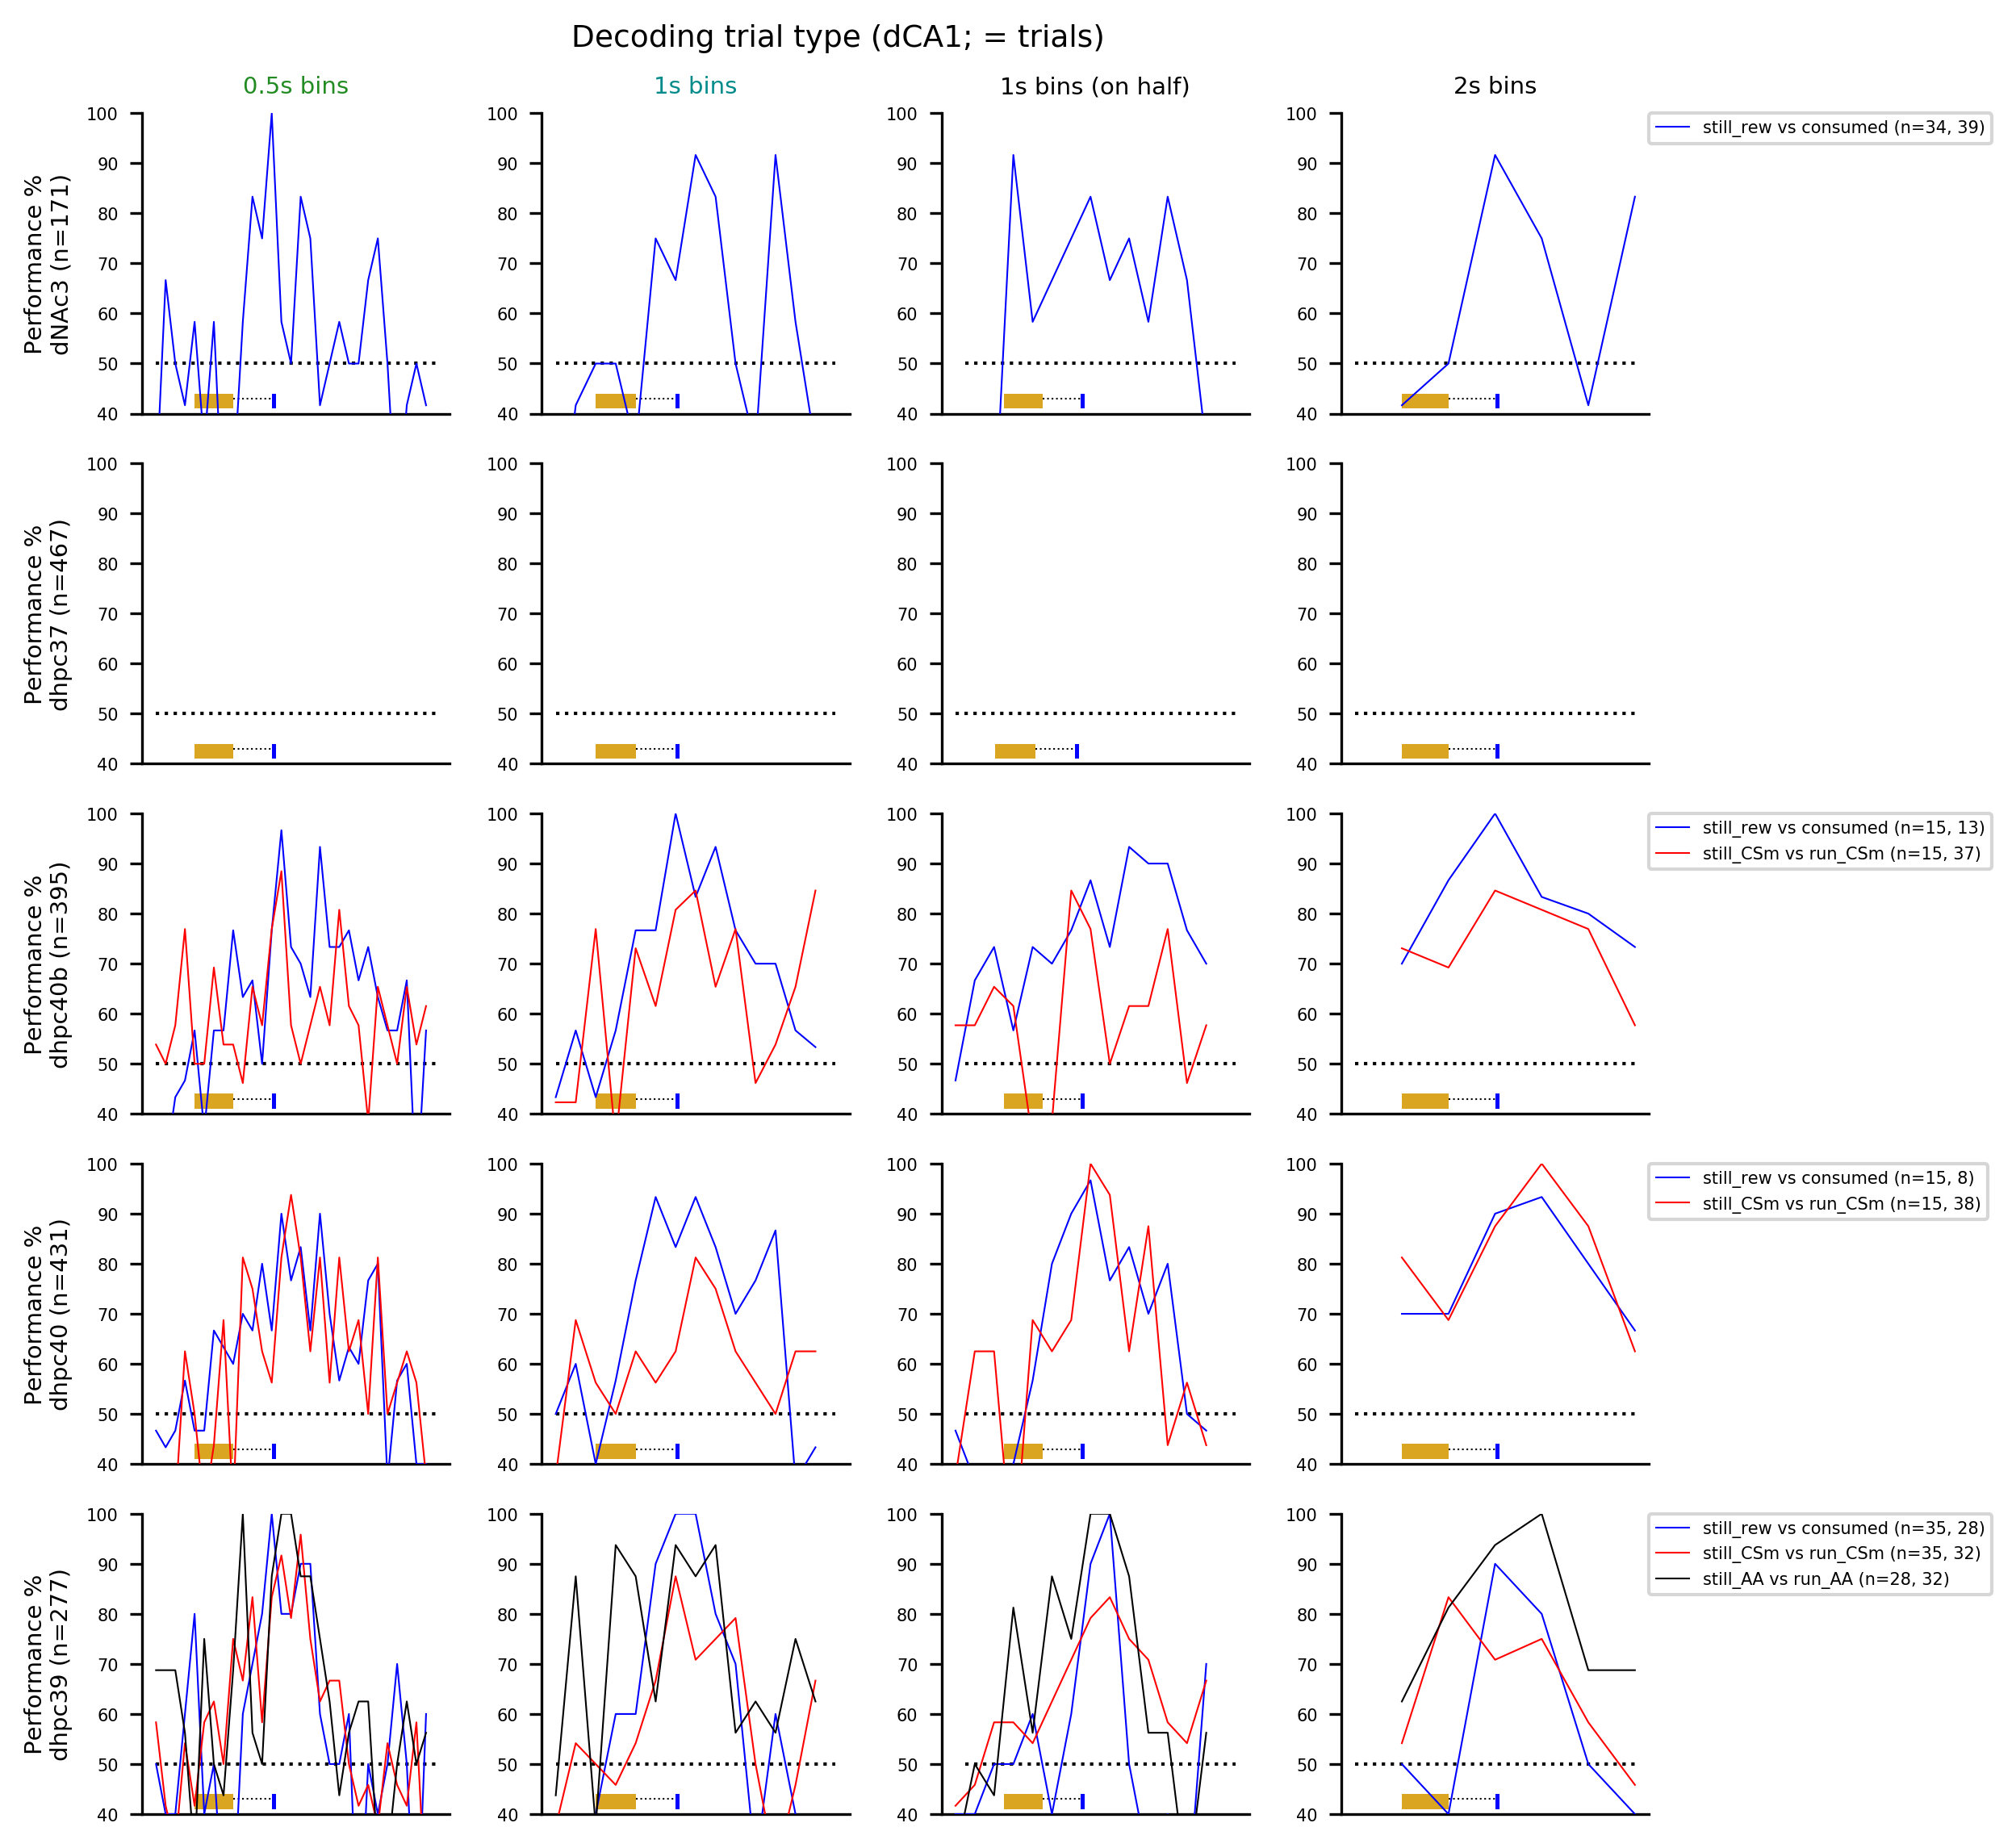

In [28]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))))

for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,cl in zip(comparisons[6:],['b','r','k'],classes[:3]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                           label='%s vs %s (n='%(comp[0],comp[1])+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[0]))))+
                           ", "+str(np.sum(eval("labels_%s[key]==%s"%(ses,cl[1]))))+")")
                m = np.array([(np.mean(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%svs_%s__%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)))/(eval("individ_scores_%s_vs_%s_%s_%s_%s[key]"%(comp[0],comp[1],tb,sess,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                #ax[y][1].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half)')
ax[0][3].set_title('2s bins')
pl.suptitle("Decoding trial type (dCA1; = trials)", fontsize=9, y=1.01)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSrun_individ.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using min

In [29]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=30
classes=[5,6],[5,7],[6,7],[1,2],[1,3],[2,3],[1,5],[2,6],[3,7]
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for cl,comp in zip(classes,comparisons):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('scores_gmin_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
            for sess in 'post',:
                print sess,t,comp[0],comp[1],
                try:
                    eval("scores_gmin_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("labels_%s"%sess),classes=cl, n_cells=340, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run_CSm post 12 consumed run_CSm post 13 consumed run_CSm post 14 consumed run_CSm post 15 consumed run_CSm post 16 consumed run_CSm post 17 consumed run_CSm post 18 consumed run_CSm post 19 consumed run_CSm post 20 consumed run_CSm post 21 consumed run_CSm post 22 consumed run_CSm post 23 consumed run_CSm post 24 consumed run_CSm post 25 consumed run_CSm post 26 consumed run_CSm post 27 consumed run_CSm post 28 consumed run_CSm post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run

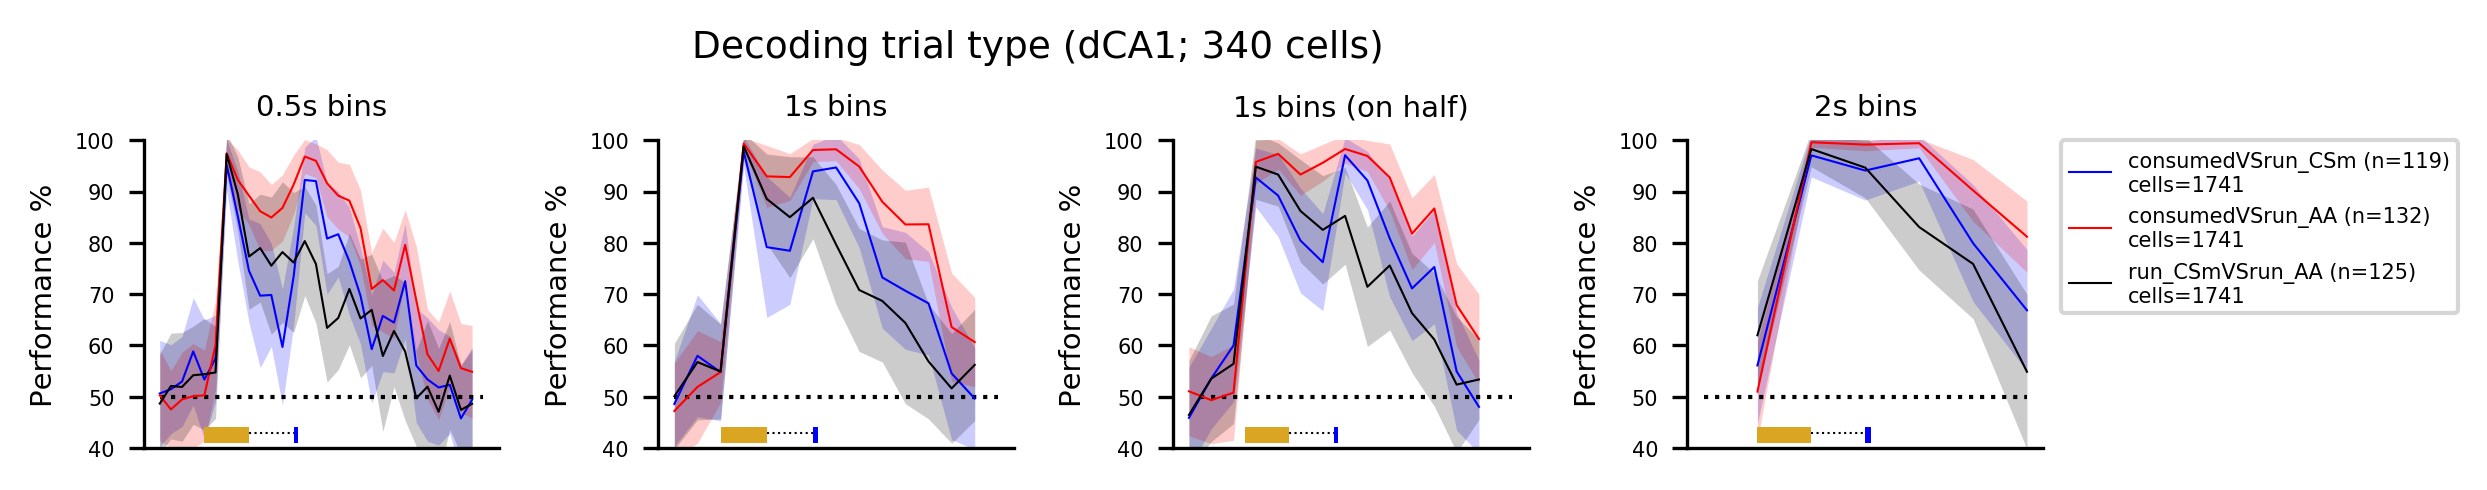

In [30]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[:3],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun_gmin.jpg'%NOTEBOOK_NAME)

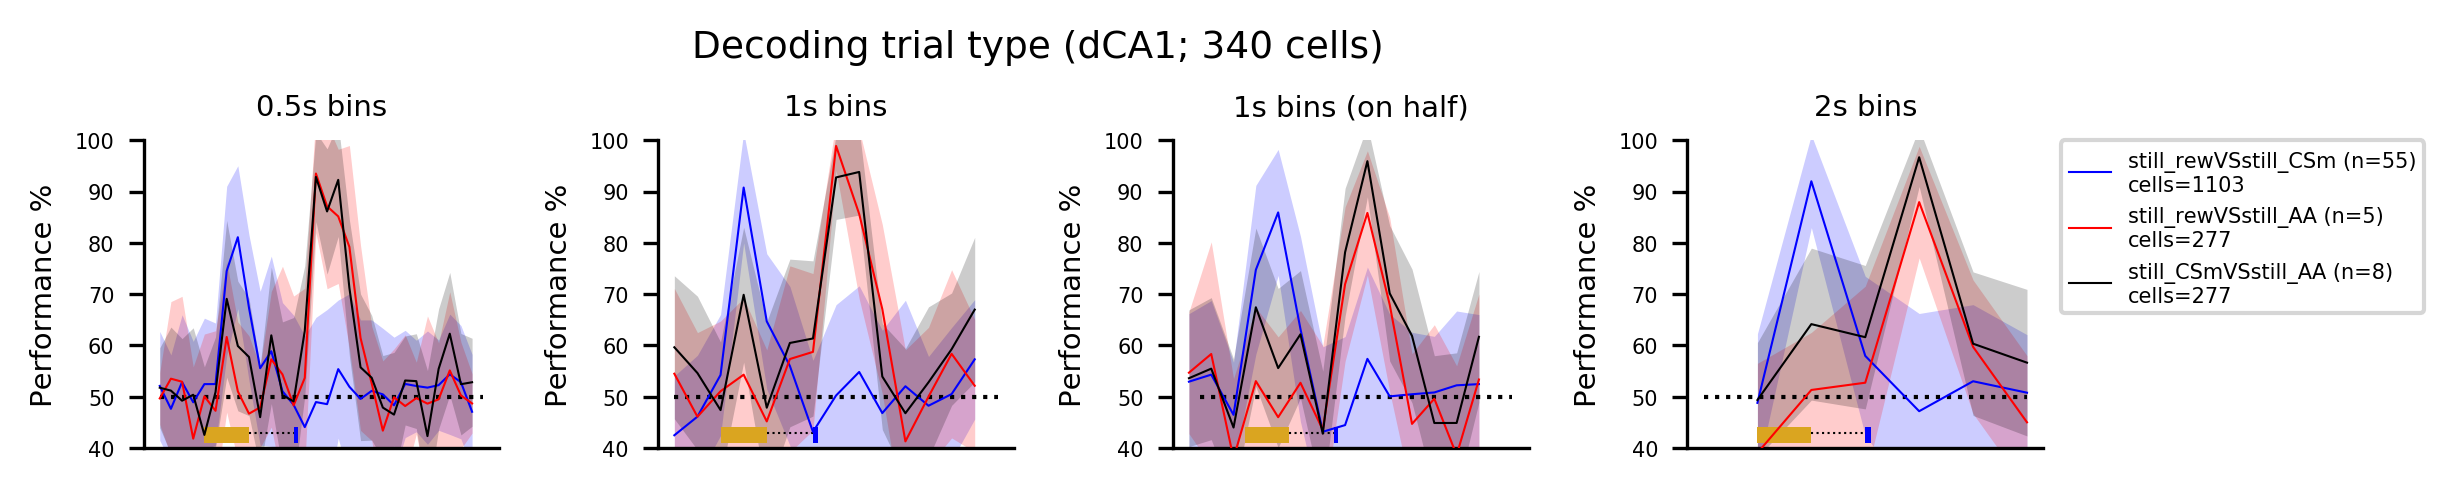

In [31]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[3:6],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSstill_gmin.jpg'%NOTEBOOK_NAME)

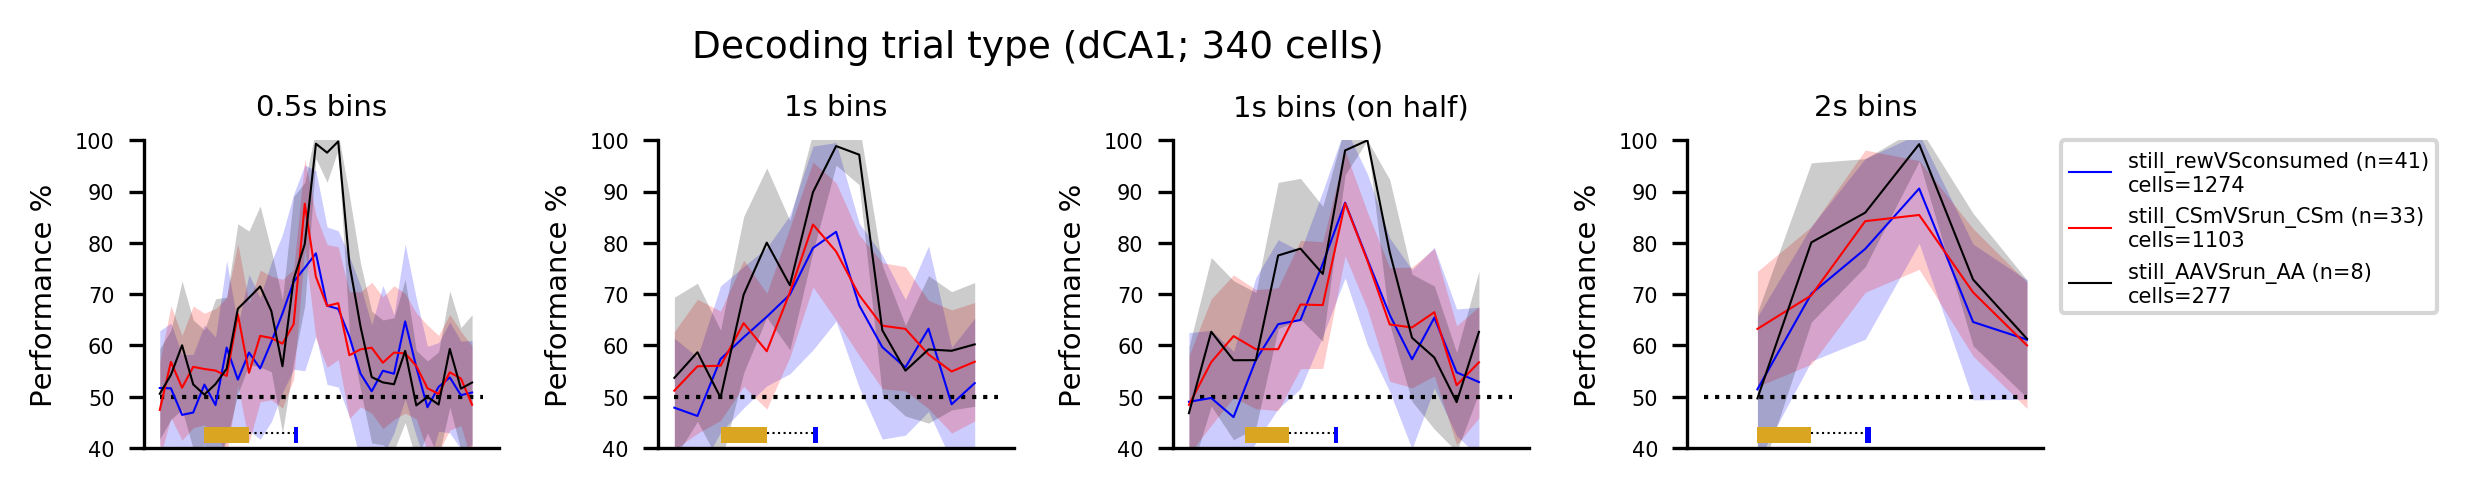

In [32]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[6:],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmin_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSrun_gmin.jpg'%NOTEBOOK_NAME)

## reduce trial type sample size to common quantity across trial types and animals (so that each animal contributes equally, for trial number at least)

In [33]:
def combine_train_test_patterns_num_trials(patterns, labels, num_trials, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #only analyze if have > 5 trials of each trial type
        if (np.shape(np.where(labels[ani]==classes[0]))[-1]>=5) and (np.shape(np.where(labels[ani]==classes[1]))[-1]>=5): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
            min_trials1=np.sum(labels[ani]==classes[0])
            min_trials2=np.sum(labels[ani]==classes[1])
            min_trials=min(min_trials1,min_trials2)
            if min_trials < num_trials:
                print ani,"trials:",min_trials,"     ",
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                    # constrain number of trials to be consistent across conditions
                    wt = wt[:num_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)
    
def do_test_within_num_trials(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns_num_trials(patterns, labels, num_trials, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

In [34]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
classes=[5,6],[5,7],[6,7],[1,2],[1,3],[2,3],[1,5],[2,6],[3,7]
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for cl,comp in zip(classes,comparisons):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('scores_gmins_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
            for sess in 'post',:
                print sess,t,comp[0],comp[1],
                try:
                    eval("scores_gmins_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = np.r_[[do_test_within_num_trials(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("labels_%s"%sess),num_trials=15, classes=cl, n_cells=340, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

post 0 consumed run_CSm dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       dhpc40b trials: 13       dhpc40 trials: 8       post 1 consumed 

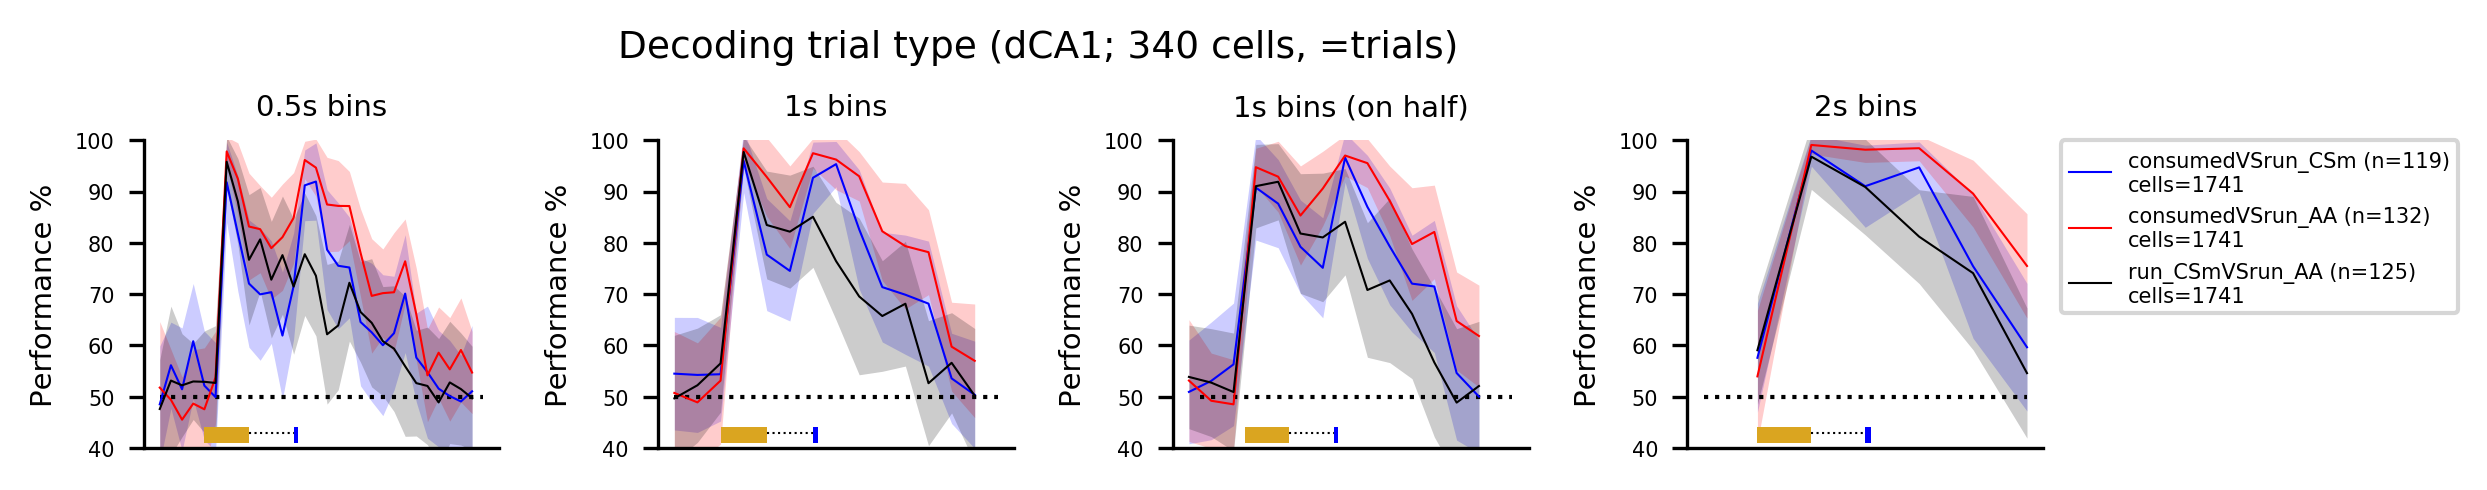

In [35]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[:3],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells, =trials)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun_gmins.jpg'%NOTEBOOK_NAME)

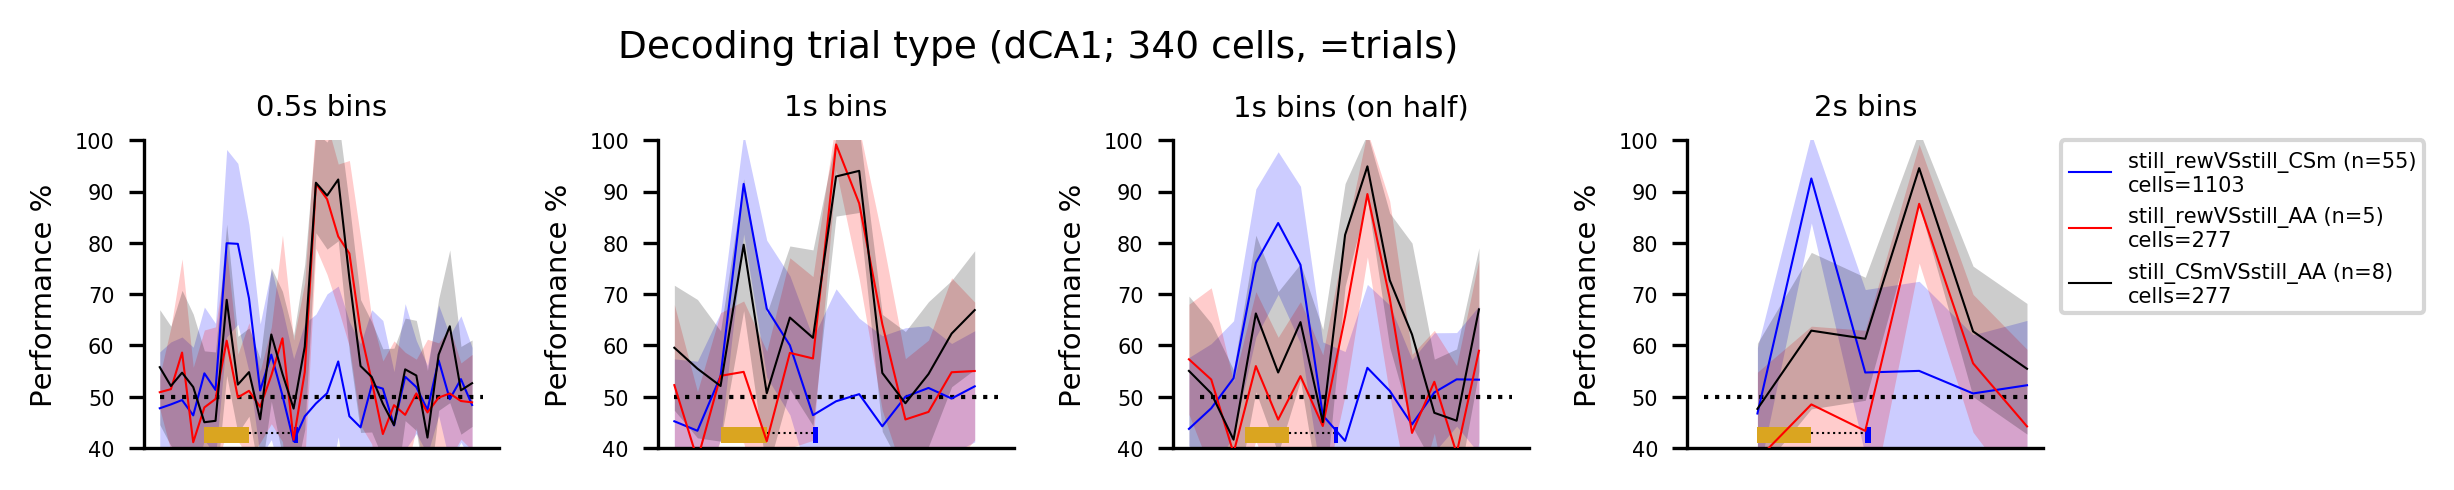

In [36]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[3:6],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells, =trials)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSstill_gmins.jpg'%NOTEBOOK_NAME)

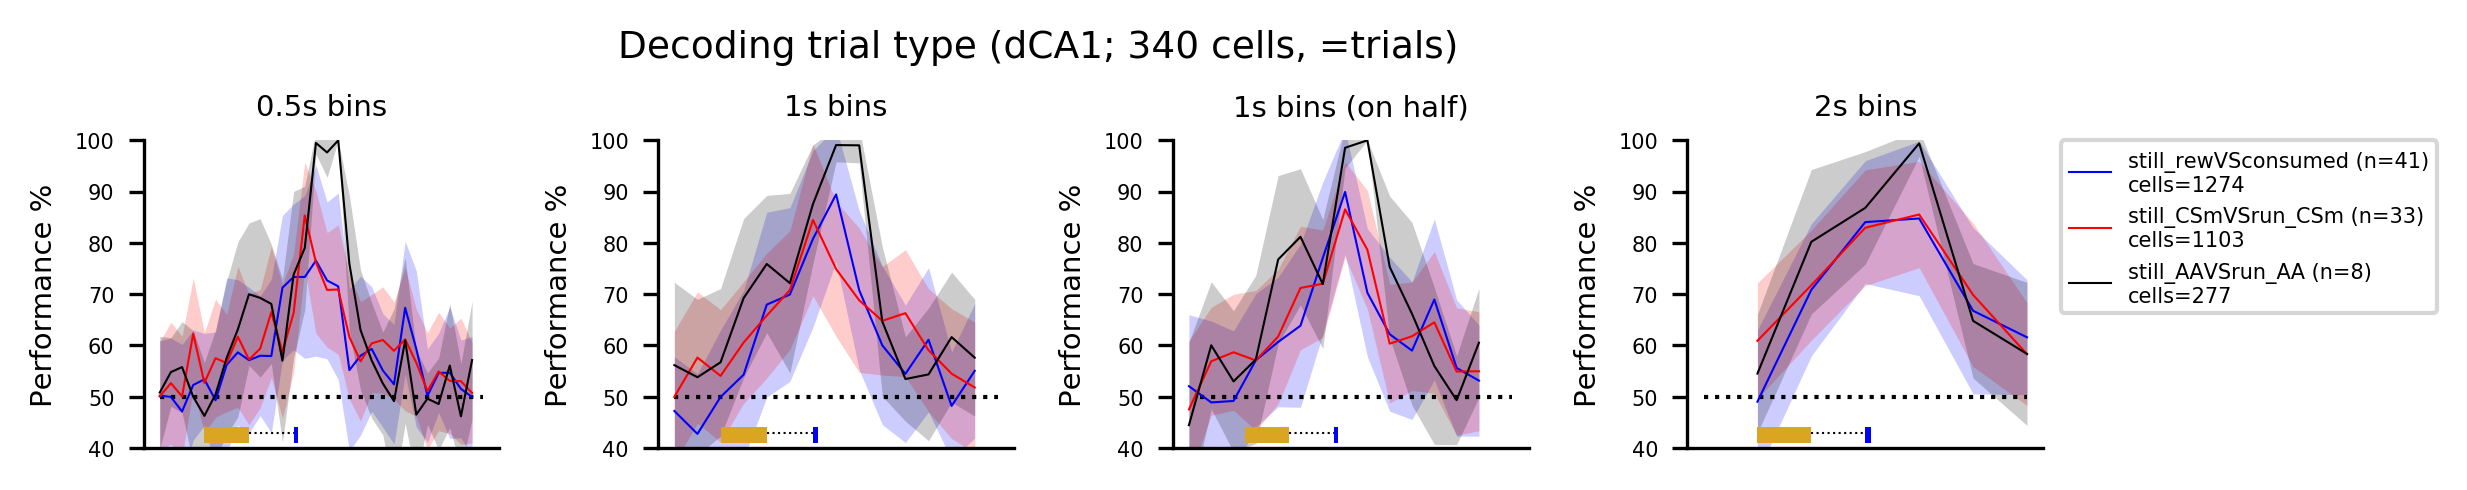

In [37]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[6:],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmins_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 340 cells, =trials)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_stillVSrun_gmins.jpg'%NOTEBOOK_NAME)

## now look at "high performing" animals only (got >=20 rewards and avoided majority of shocks)

In [38]:
def combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        if ani in high_performing_animals:
        #only analyze if have > 5 trials of each trial type
            if (np.shape(np.where(labels[ani]==classes[0]))[-1]>=5) and (np.shape(np.where(labels[ani]==classes[1]))[-1]>=5): #only include animal if it has x trials of specified trial type
                which_trains = []
                which_tests = []
                #find min number of trials of both trial types, then downsample the type with more trials to match min
                #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
                min_trials1=np.sum(labels[ani]==classes[0])
                min_trials2=np.sum(labels[ani]==classes[1])
                min_trials=min(min_trials1,min_trials2)
                if min_trials < num_trials:
                    print ani,"trials:",min_trials,"   ",
                for l in classes:
                    if l>=0:
                        wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                        # constrain number of trials to be consistent across conditions
                        wt = wt[:num_trials]
                        if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                            wT = wt[:int(len(wt)*train_test_split)]
                            which_trains.append(wt[int(len(wt)*train_test_split):])
                            which_tests.append(wT)
                        else:
                            which_trains.append(wt)
                which_train[ani] = np.concatenate(which_trains)
                if train_test_split<1:
                    which_test[ani] = np.concatenate(which_tests)
            else:
                not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)
    
def do_test_within_num_trials_HP(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

def Not_Run_HP(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, **args)
    return not_run,sum(which_cells)

In [39]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
classes=[5,6],[5,7],[6,7],[1,2],[1,3],[2,3],[1,5],[2,6],[3,7]
comparisons=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA'],['still_rew','still_CSm'],\
['still_rew','still_AA'],['still_CSm','still_AA'],['still_rew','consumed'],['still_CSm','run_CSm'],['still_AA','run_AA']
for cl,comp in zip(classes,comparisons):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('scores_gmins_HP_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
            for sess in 'post',:
                print sess,t,comp[0],comp[1],
                try:
                    eval("scores_gmins_HP_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = np.r_[[do_test_within_num_trials_HP(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("labels_%s"%sess),num_trials=20, classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
        
    try:
        exec("not_run_HP,total_cells_HP_%s_vs_%s = Not_Run_HP(patterns_%s_%s_%s,labels_%s,num_trials=20,classes=cl, n_cells=None,\
              relabel=None)"%(comp[0],comp[1],tb,sess,t,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run_HP
        print "total cells =",eval("total_cells_HP_%s_vs_%s"%(comp[0],comp[1]))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"

post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run_CSm post 12 consumed run_CSm post 13 consumed run_CSm post 14 consumed run_CSm post 15 consumed run_CSm post 16 consumed run_CSm post 17 consumed run_CSm post 18 consumed run_CSm post 19 consumed run_CSm post 20 consumed run_CSm post 21 consumed run_CSm post 22 consumed run_CSm post 23 consumed run_CSm post 24 consumed run_CSm post 25 consumed run_CSm post 26 consumed run_CSm post 27 consumed run_CSm post 28 consumed run_CSm post 0 consumed run_CSm post 1 consumed run_CSm post 2 consumed run_CSm post 3 consumed run_CSm post 4 consumed run_CSm post 5 consumed run_CSm post 6 consumed run_CSm post 7 consumed run_CSm post 8 consumed run_CSm post 9 consumed run_CSm post 10 consumed run_CSm post 11 consumed run

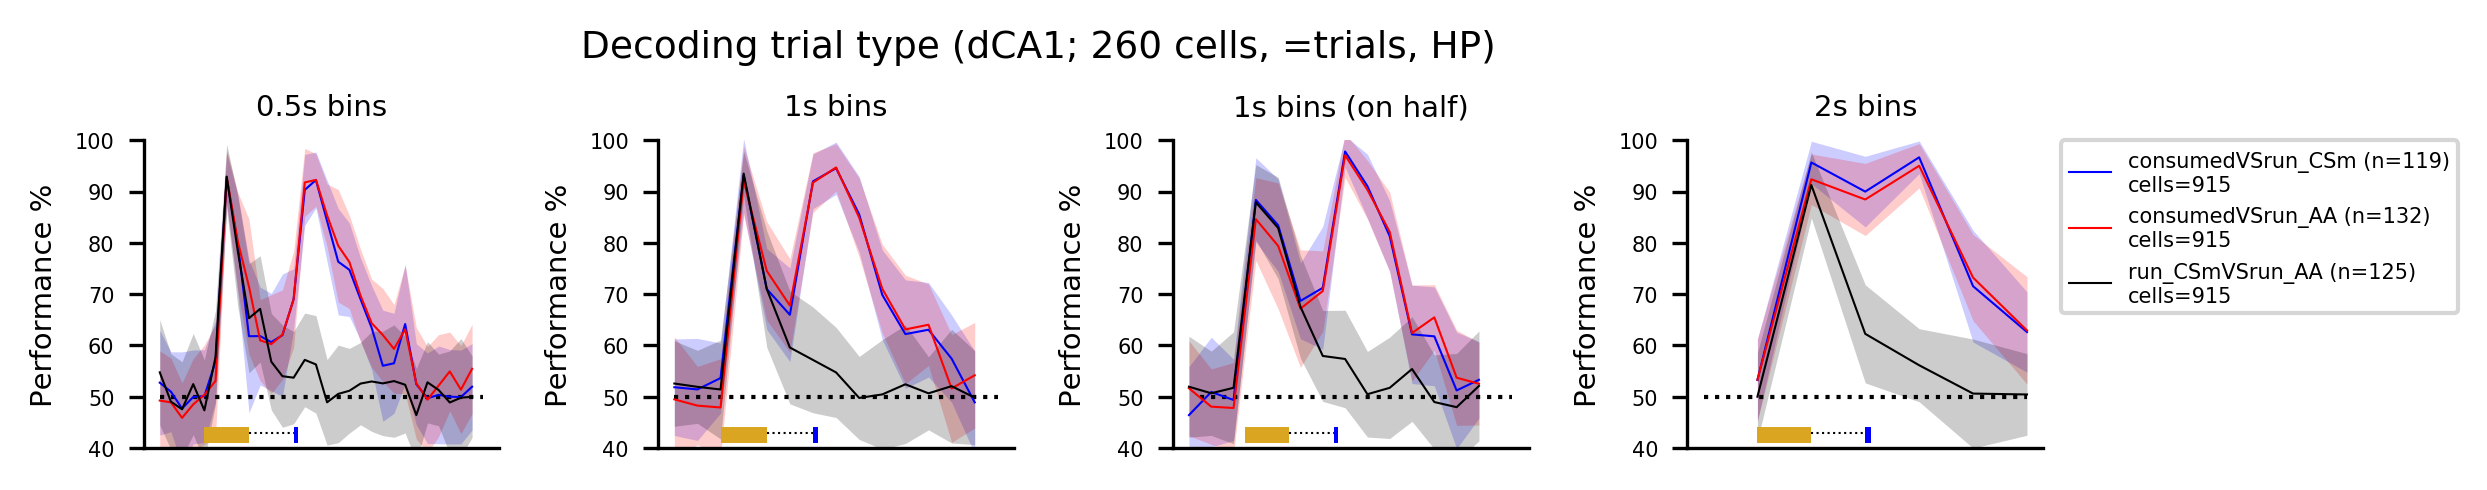

In [40]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[:3],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_HP_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s (n='%(comp[0],comp[1])+str(eval("total_%s_vs_%s_trials_post"%(comp[0],comp[1])))+")\ncells="+str(eval("total_cells_HP_%s_vs_%s"%(comp[0],comp[1]))))
            m = np.array([(np.mean(eval("scores_gmins_HP_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmins_HP_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 260 cells, =trials, HP)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun_gmins_HP.jpg'%NOTEBOOK_NAME)

### only use trials where speed is similar (to control for diff speeds across trial types)

In [41]:
#import speeds and timings of odor onsets
for sess in sessions:
    for var in ['speed','speed_times','STIMs_ons','is_rewardedt','is_avoidedt','is_CSm_enabledt']:
        try:
            exec("%s_%s = dict(zip(%s_animals, [ut.load_variable('%s',\
                                                               '../%%s/%s/notebooks/autorestore/preprocessing/'%%ani)\
                                                      for ani in %s_animals]))"%(var,sess,sess,var,sess,sess))
        except:
            print 'nope %s %s'%(var,sess),

nope speed expo nope speed_times expo nope STIMs_ons expo nope is_rewardedt expo nope is_avoidedt expo nope is_CSm_enabledt expo nope speed pre nope speed_times pre nope STIMs_ons pre nope is_rewardedt pre nope is_avoidedt pre nope is_CSm_enabledt pre nope speed mid nope speed_times mid nope STIMs_ons mid nope is_rewardedt mid nope is_avoidedt mid nope is_CSm_enabledt mid


In [43]:
def combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    speed_patterns={}
    speed_labels={}
    tot_trials=0
    for ani in patterns.keys():
        #only keep trials where running avg is within window defined earlier
        speed_patterns[ani]=patterns[ani][speed[ani]]
        speed_labels[ani]=labels[ani][speed[ani]]
        #only analyze if have > 5 trials of each trial type
        if (sum(speed_labels[ani]==classes[0])>=3) and (sum(speed_labels[ani]==classes[1])>=3): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
            min_trials1=np.sum(speed_labels[ani]==classes[0])
            min_trials2=np.sum(speed_labels[ani]==classes[1])
            min_trials=min(min_trials1,min_trials2)
            if min_trials < num_trials:
                print ani,"trials:",min_trials,"     ",
            tot_trials = tot_trials + min(min_trials,num_trials)
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(speed_labels[ani]==l)[0])[:min_trials]
                    # constrain number of trials to be consistent across conditions
                    wt = wt[:num_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    #find total number of trials used across all animals
    
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        patterns_t[ani] = speed_patterns[ani][which_train[ani]]
        labels_t[ani] = speed_labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            patterns_T[ani] = speed_patterns[ani][which_test[ani]]
            labels_T[ani] = speed_labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells,tot_trials)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells,tot_trials)
    
def do_test_within_num_trials_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

def Not_Run_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed,**args)
    return not_run,sum(which_cells),tot_trials

In [248]:
#get mean running speed for ~1s trace period prior to spout moving in
min_avg_speed = 9
max_avg_speed = 15
for sess in sessions:
    try:
        exec("mean_trace_speed_%s={}"%sess)
        exec("is_mean_speedt_%s={}"%sess)
        for ani in eval("speed_%s.keys()"%sess):
            exec("mean_trace_speed_%s[ani]=[]"%sess)
            exec("is_mean_speedt_%s[ani]=[]"%sess)
            for i, stim_ons in enumerate(eval("STIMs_ons_%s[ani]"%sess)):
                #only get data points during trace period before spout moved in
                exec("speed_filt = ((speed_times_%s[ani]-stim_ons)>2) * ((speed_times_%s[ani]-stim_ons)<3)"%(sess,sess))
                exec("mean = np.mean(np.r_[speed_%s[ani]][speed_filt])"%(sess))
                eval("mean_trace_speed_%s[ani].append(mean)"%(sess))
            for x in eval("mean_trace_speed_%s[ani]"%sess):
                eval("is_mean_speedt_%s[ani].append(min_avg_speed <= x <= max_avg_speed)"%sess)
    except:
        print 'NOPE %s' %sess

NOPE expo
NOPE pre
NOPE mid


In [87]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
num_trials=10
classes_speed=[5,6],[5,7],[6,7]
comparisons_speed=['consumed','run_CSm'],['consumed','run_AA'],['run_CSm','run_AA']
for cl,comp in zip(classes_speed,comparisons_speed):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('scores_gmins_speed_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
            for sess in 'post',:
                print sess,t,comp[0],comp[1],
                #try:
                eval("scores_gmins_speed_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = \
                    np.r_[[do_test_within_num_trials_speed(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("labels_%s"%(sess)),num_trials=num_trials, speed=eval("is_mean_speedt_%s"%sess),classes=cl,
                        n_cells=260, relabel=None) for i in range(n_loops)]]
                #except:
                #    print 'NOPE'
                
    try:
        exec("not_run_speed,total_cells_speed_%s_vs_%s,tot_trials_%s_vs_%s = Not_Run_speed(patterns_%s_%s_%s,labels_%s,num_trials=num_trials,\
        speed=is_mean_speedt_%s,classes=cl, n_cells=None,relabel=None)"%(comp[0],comp[1],comp[0],comp[1],tb,sess,t,sess,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run_speed
        print "total cells =",eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1]))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
    print "Total Trials = ",eval("tot_trials_%s_vs_%s"%(comp[0],comp[1]))

post 0 consumed run_CSm dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       dhpc40b trials: 3       dhpc39 trials: 7       post 1 consumed run_CSm dhpc40b tria

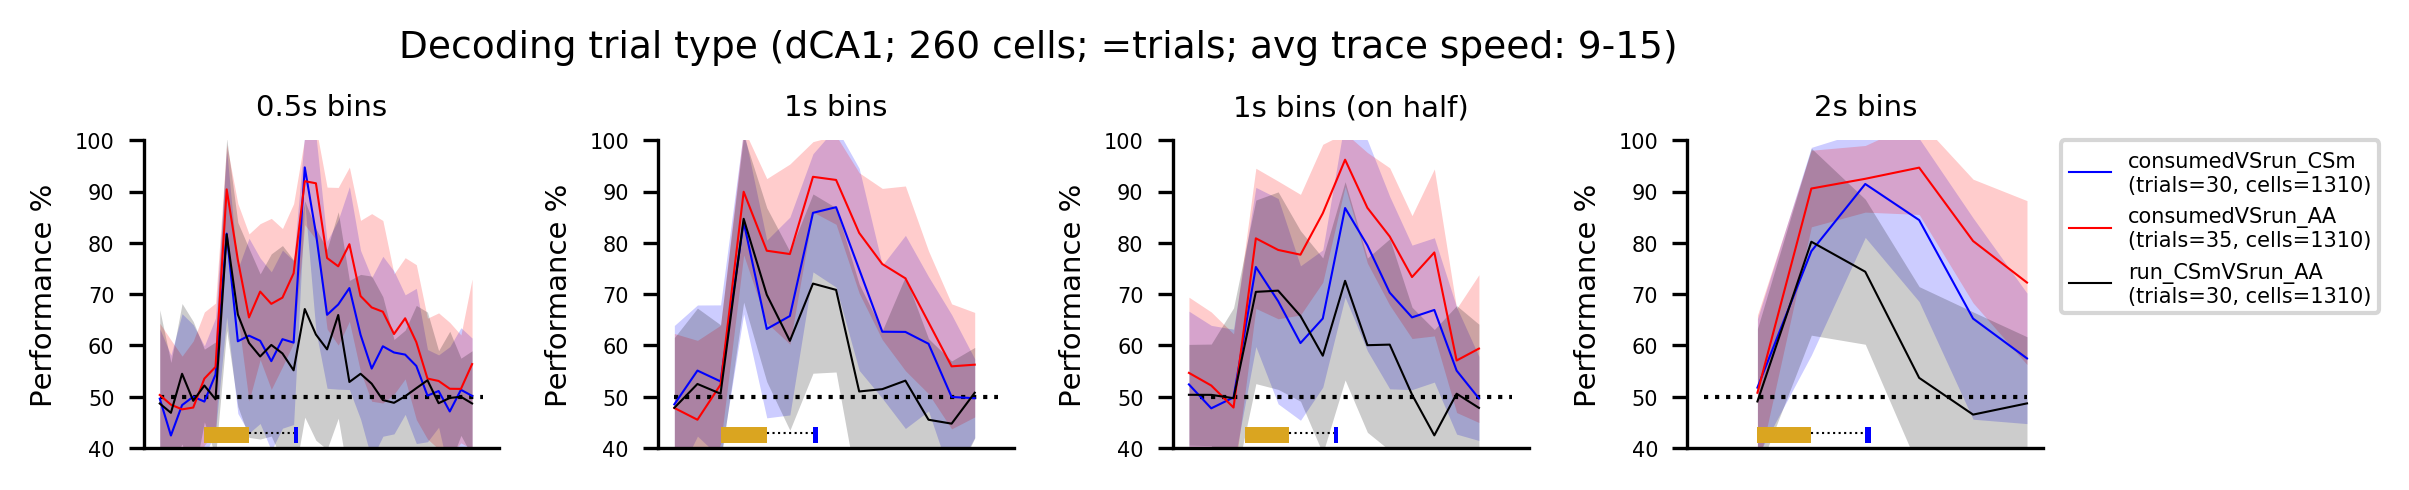

In [89]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(comparisons[:3],['b','r','k']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("scores_gmins_speed_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("scores_gmins_speed_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("scores_gmins_speed_%s_%s_%s_vs_%s['post']"%(tb,t,comp[0],comp[1])))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding trial type (dCA1; 260 cells; =trials; avg trace speed: 9-15)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

### decode low speed vs high speed trials (separate by median speed during trace for each animal and each specific trial type)

In [ ]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [249]:
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    exec("above_speed_median_post_%s = {}"%(tt))
    exec("below_speed_median_post_%s = {}"%(tt))
    for ani in speed_post.keys():
        exec("above_speed_median_post_%s[ani]=mean_trace_speed_post[ani]>\
              ((np.median(np.r_[mean_trace_speed_post[ani]][labels_post[ani]==%d])))"%(tt,lab))
        exec("below_speed_median_post_%s[ani]=mean_trace_speed_post[ani]<\
              ((np.median(np.r_[mean_trace_speed_post[ani]][labels_post[ani]==%d])))"%(tt,lab))

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [227]:
for ani in above_speed_median_post.keys():
    print ani, sum(below_speed_median_post_consumed[ani])

dhpc40b 95
dhpc37 86
dNAc3 57
dhpc40 76
dhpc39 79


In [250]:
import copy
speed_labels_post = copy.deepcopy(labels_post)
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    for ani in speed_labels_post.keys():
        for i, label in enumerate(speed_labels_post[ani]):
            if label==lab and eval("below_speed_median_post_%s[ani][i]==True"%(tt)):
                speed_labels_post[ani][i]=lab*10
            if label==lab and eval("above_speed_median_post_%s[ani][i]==True"%(tt)):
                speed_labels_post[ani][i]=lab*100

In [251]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp,
    for tb,i in zip(bins,range(len(bins))):
        print".",
        for t in range(bin_ranges[i]): # number of time bins
            exec('speed_scores_gmin_%s_%s_%s = {}'%(tb,t,comp))
            for sess in 'post',:
                try:
                    eval("speed_scores_gmin_%s_%s_%s"%(tb,t,comp))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("speed_labels_%s"%sess),classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

still_rew . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE still_CSm . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE still_AA . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE no

In [252]:
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp
    try:
        exec("speed_not_run,speed_total_cells_%s = Not_Run(patterns_%s_post_%s,speed_labels_post,classes=cl, n_cells=None,\
              relabel=None)"%(comp,tb,t))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",speed_not_run
        print "total cells =",eval("speed_total_cells_%s"%(comp))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"

    for key in speed_labels_post.keys():
        v0=0
        v1=0
        for val in speed_labels_post[key]:
            if val == cl[0]:
                v0 += 1
            if val == cl[1]:
                v1 += 1
        print v0,v1
        exec("vals_%s = min(v0,v1)"%key)
        print "animal %s="%key,eval("vals_%s"%key),"min trials"
    sum_vals=0
    for key in speed_labels_post.keys():
        if eval("vals_%s"%key)>=5:
            sum_vals = sum_vals + eval("vals_%s"%key)
    exec("total_%s_trials_post = sum_vals"%(comp))
    print "total_%s_trials_post ="%(comp),eval("total_%s_trials_post"%(comp)),"\n"

still_rew

NO ANIMALS MET CRITERIA (all had too few trials)
4 6
animal dhpc40b= 4 min trials
0 1
animal dhpc37= 0 min trials
0 2
animal dNAc3= 0 min trials
1 8
animal dhpc40= 1 min trials
0 1
animal dhpc39= 0 min trials
total_still_rew_trials_post = 0 

still_CSm

NO ANIMALS MET CRITERIA (all had too few trials)
4 11
animal dhpc40b= 4 min trials
0 0
animal dhpc37= 0 min trials
0 0
animal dNAc3= 0 min trials
3 8
animal dhpc40= 3 min trials
1 5
animal dhpc39= 1 min trials
total_still_CSm_trials_post = 0 

still_AA

NO ANIMALS MET CRITERIA (all had too few trials)
1 1
animal dhpc40b= 1 min trials
1 1
animal dhpc37= 1 min trials
0 0
animal dNAc3= 0 min trials
1 1
animal dhpc40= 1 min trials
0 3
animal dhpc39= 0 min trials
total_still_AA_trials_post = 0 

not_consumed

NO ANIMALS MET CRITERIA (all had too few trials)
0 0
animal dhpc40b= 0 min trials
0 0
animal dhpc37= 0 min trials
0 0
animal dNAc3= 0 min trials
0 0
animal dhpc40= 0 min trials
0 0
animal dhpc39= 0 min trials
total_not_consum

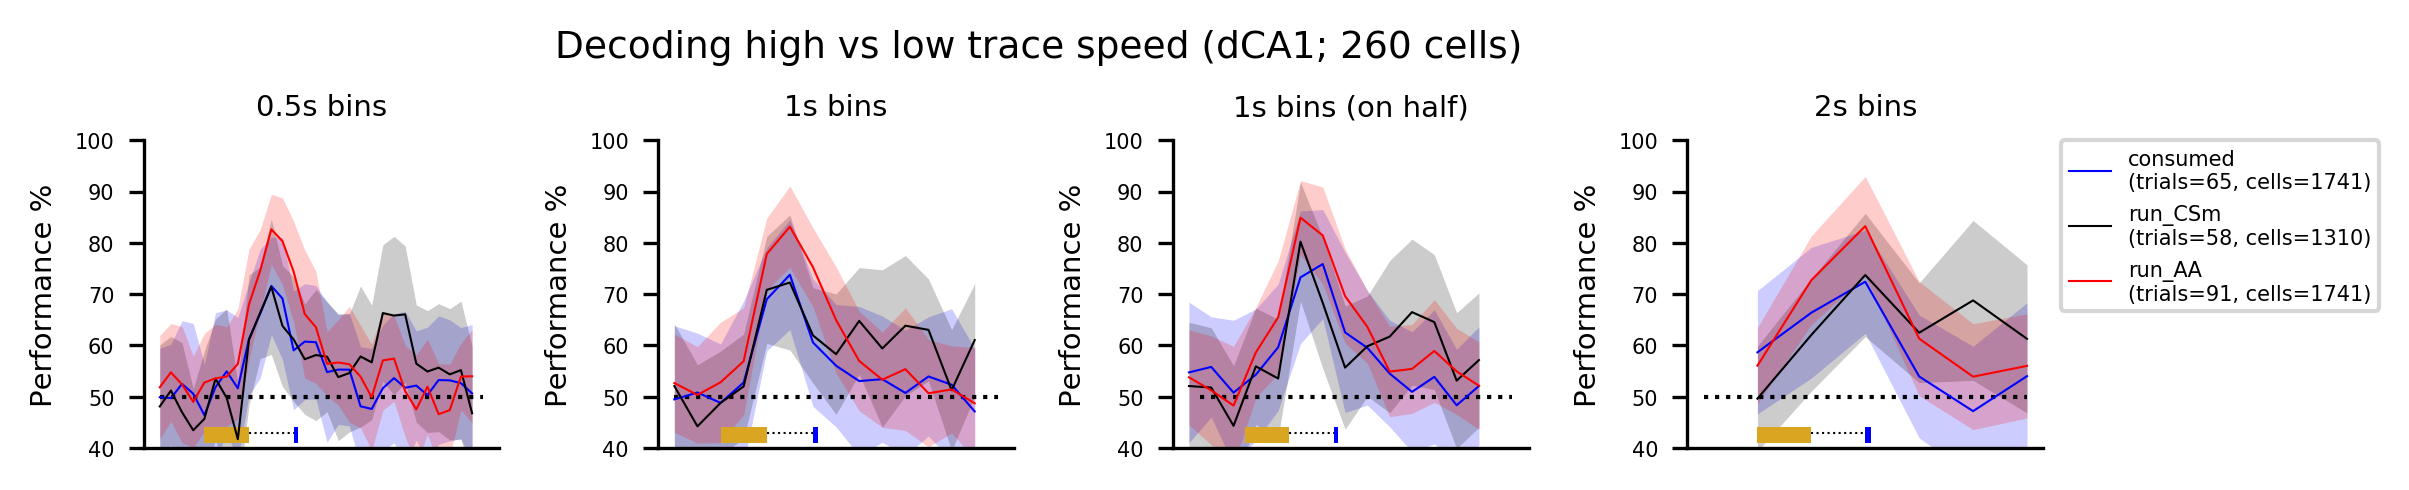

In [253]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(speed_comparisons[4:],['b','k','r']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        #try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%s\n(trials='%(comp)+str(eval("total_%s_trials_post"%(comp)))+", cells="+str(eval("speed_total_cells_%s"%(comp)))+")")
#                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        #except:
        #    continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding high vs low trace speed (dCA1; 260 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

## now use a time bin after US period (7-8s) just before spout moving out for speed comparison

In [369]:
#get mean running speed for ~1s post trial period prior to spout moving out
for sess in 'post',:
    #try:
        exec("mean_late_speed_%s={}"%sess)
        #exec("is_mean_speedt_%s={}"%sess)
        for ani in eval("speed_%s.keys()"%sess):
            exec("mean_late_speed_%s[ani]=[]"%sess)
        #    exec("is_mean_speedt_%s[ani]=[]"%sess)
            for i, stim_ons in enumerate(eval("STIMs_ons_%s[ani]"%sess)):
                #only get data points during trace period before spout moved in
                exec("speed_filt = ((speed_times_%s[ani]-stim_ons)>7) * ((speed_times_%s[ani]-stim_ons)<8)"%(sess,sess))
                exec("mean = np.mean(np.r_[speed_%s[ani]][speed_filt])"%(sess))
                eval("mean_late_speed_%s[ani].append(mean)"%(sess))
        #    for x in eval("mean_late_speed_%s[ani]"%sess):
        #        eval("is_mean_speedt_%s[ani].append(min_avg_speed <= x <= max_avg_speed)"%sess)
    #except:
    #    print 'NOPE %s' %sess

In [370]:
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    exec("above_late_speed_median_post_%s = {}"%(tt))
    exec("below_late_speed_median_post_%s = {}"%(tt))
    for ani in speed_post.keys():
        exec("above_late_speed_median_post_%s[ani]=mean_late_speed_post[ani]>\
              ((np.median(np.r_[mean_late_speed_post[ani]][labels_post[ani]==%d])))"%(tt,lab))
        exec("below_late_speed_median_post_%s[ani]=mean_late_speed_post[ani]<\
              ((np.median(np.r_[mean_late_speed_post[ani]][labels_post[ani]==%d])))"%(tt,lab))

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [371]:
for lab,tt in zip (range(5,8),['consumed','run_CSm','run_AA']):
    for ani in mean_late_speed_post:
        print tt,ani,eval("((np.median(np.r_[mean_late_speed_post[ani]][labels_post[ani]==%d])))"%(lab))

consumed dhpc40b 0.6
consumed dhpc37 0.0
consumed dNAc3 0.2
consumed dhpc40 0.4
consumed dhpc39 0.2
run_CSm dhpc40b 0.6
run_CSm dhpc37 0.0
run_CSm dNAc3 0.2
run_CSm dhpc40 2.5
run_CSm dhpc39 0.0
run_AA dhpc40b 13.8
run_AA dhpc37 0.0
run_AA dNAc3 0.5
run_AA dhpc40 12.0
run_AA dhpc39 0.0


In [372]:
import copy
late_speed_labels_post = copy.deepcopy(labels_post)
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    for ani in late_speed_labels_post.keys():
        for i, label in enumerate(late_speed_labels_post[ani]):
            if label==lab and eval("below_late_speed_median_post_%s[ani][i]==True"%(tt)):
                late_speed_labels_post[ani][i]=lab*10
            if label==lab and eval("above_late_speed_median_post_%s[ani][i]==True"%(tt)):
                late_speed_labels_post[ani][i]=lab*100

In [436]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=20
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp,
    for tb,i in zip(bins,range(len(bins))):
        print".",
        for t in range(bin_ranges[i]): # number of time bins
            exec('late_speed_scores_gmin_%s_%s_%s = {}'%(tb,t,comp))
            for sess in 'post',:
                try:
                    eval("late_speed_scores_gmin_%s_%s_%s"%(tb,t,comp))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s"%(tb,sess,t)),
                        eval("late_speed_labels_%s"%sess),classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

still_rew . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE still_CSm . . . . still_AA . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE not_consumed . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE NOPE N

In [374]:
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp
    try:
        exec("late_speed_not_run,late_speed_total_cells_%s = Not_Run(patterns_%s_post_%s,late_speed_labels_post,classes=cl, n_cells=None,\
              relabel=None)"%(comp,tb,t))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",speed_not_run
        print "total cells =",eval("late_speed_total_cells_%s"%(comp))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"

    for key in late_speed_labels_post.keys():
        v0=0
        v1=0
        for val in late_speed_labels_post[key]:
            if val == cl[0]:
                v0 += 1
            if val == cl[1]:
                v1 += 1
        print v0,v1
        exec("vals_%s = min(v0,v1)"%key)
        print "animal %s="%key,eval("vals_%s"%key),"min trials"
    sum_vals=0
    for key in late_speed_labels_post.keys():
        if eval("vals_%s"%key)>=5:
            sum_vals = sum_vals + eval("vals_%s"%key)
    exec("total_%s_trials_late_speed_post = sum_vals"%(comp))
    print "total_%s_trials_late_speed_post ="%(comp),eval("total_%s_trials_late_speed_post"%(comp)),"\n"

still_rew

NO ANIMALS MET CRITERIA (all had too few trials)
2 10
animal dhpc40b= 2 min trials
0 1
animal dhpc37= 0 min trials
3 3
animal dNAc3= 3 min trials
2 5
animal dhpc40= 2 min trials
2 2
animal dhpc39= 2 min trials
total_still_rew_trials_late_speed_post = 0 

still_CSm


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 277
1 10
animal dhpc40b= 1 min trials
0 0
animal dhpc37= 0 min trials
0 0
animal dNAc3= 0 min trials
1 8
animal dhpc40= 1 min trials
6 6
animal dhpc39= 6 min trials
total_still_CSm_trials_late_speed_post = 6 

still_AA

NO ANIMALS MET CRITERIA (all had too few trials)
1 1
animal dhpc40b= 1 min trials
1 1
animal dhpc37= 1 min trials
0 0
animal dNAc3= 0 min trials
1 1
animal dhpc40= 1 min trials
1 2
animal dhpc39= 1 min trials
total_still_AA_trials_late_speed_post = 0 

not_consumed

NO ANIMALS MET CRITERIA (all had too few trials)
0 0
animal dhpc40b= 0 min trials
0 0
animal dhpc37= 0 min trials
0 0
animal dNAc3= 0 min trials
0 0
animal dhpc40= 0 min trial

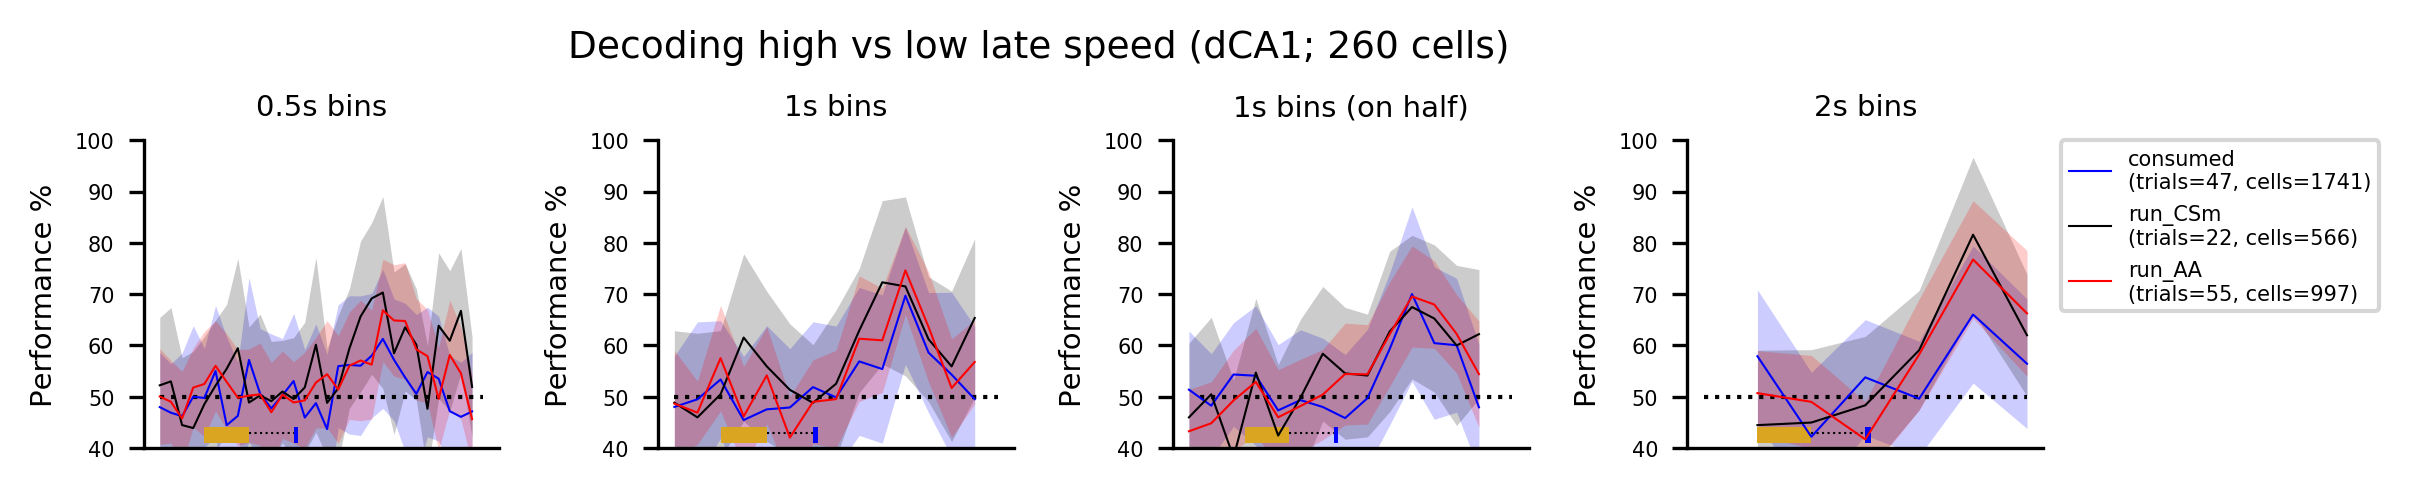

In [375]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(speed_comparisons[4:],['b','k','r']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        #try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%s\n(trials='%(comp)+str(eval("total_%s_trials_late_speed_post"%(comp)))+", cells="+str(eval("late_speed_total_cells_%s"%(comp)))+")")
#                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        #except:
        #    continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding high vs low late speed (dCA1; 260 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

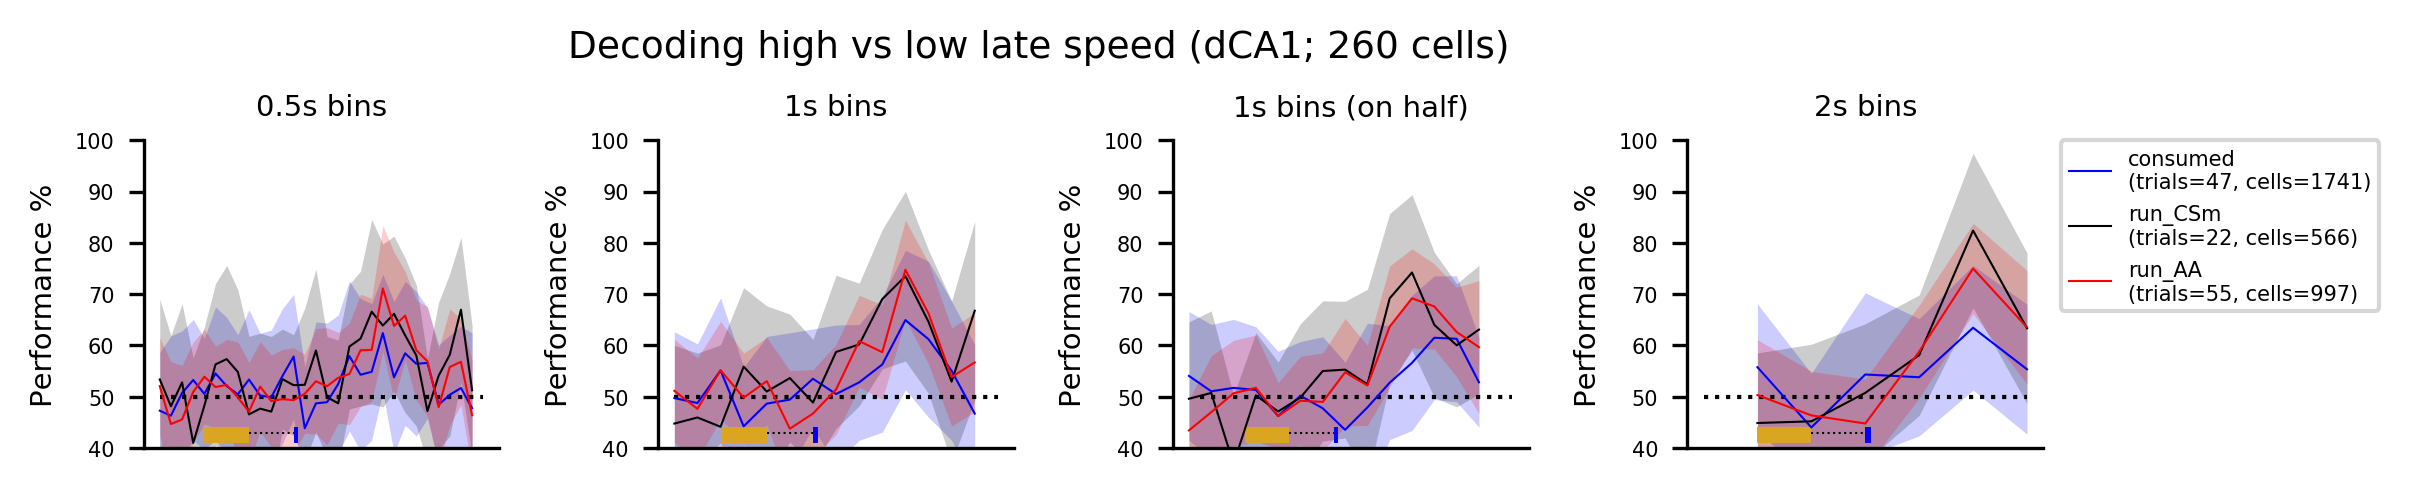

In [437]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c in zip(speed_comparisons[4:],['b','k','r']):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        #try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,
                       label='%s\n(trials='%(comp)+str(eval("total_%s_trials_late_speed_post"%(comp)))+", cells="+str(eval("late_speed_total_cells_%s"%(comp)))+")")
#                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("late_speed_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        #except:
        #    continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins')
ax[1].set_title('1s bins')
ax[2].set_title('1s bins (on half)')
ax[3].set_title('2s bins')
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding high vs low late speed (dCA1; 260 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

# decode high vs low at each time bin (before was taking high vs low trials for a specific time bin and applying to all other bins, but here will get high vs low for each bin and decode using those trials for that bin only)

In [419]:
#get mean running speed for ~1s post trial period prior to spout moving out
for t, st,m in zip(range(14),range(-3,12),[[-3,-2],[-2,-1],[-1,0],[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11]]):
    for sess in 'post',:
        #try:
            exec("mean_late_speed_%s_%s={}"%(t,sess))
            #exec("is_mean_speedt_%s={}"%sess)
            for ani in eval("speed_%s.keys()"%sess):
                exec("mean_late_speed_%s_%s[ani]=[]"%(t,sess))
            #    exec("is_mean_speedt_%s[ani]=[]"%sess)
                for i, stim_ons in enumerate(eval("STIMs_ons_%s[ani]"%sess)):
                    #only get data points during trace period before spout moved in
                    exec("speed_filt = ((speed_times_%s[ani]-stim_ons)>m[0]) * ((speed_times_%s[ani]-stim_ons)<m[1])"%(sess,sess))
                    exec("mean = np.mean(np.r_[speed_%s[ani]][speed_filt])"%(sess))
                    eval("mean_late_speed_%s_%s[ani].append(mean)"%(t,sess))
            #    for x in eval("mean_late0_speed_%s[ani]"%sess):
            #        eval("is_mean_speedt_%s[ani].append(min_avg_speed <= x <= max_avg_speed)"%sess)
        #except:
        #    print 'NOPE %s' %sess

In [420]:
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    for t in range(14):
        exec("above_late_speed_median_%s_post_%s = {}"%(t,tt))
        exec("below_late_speed_median_%s_post_%s = {}"%(t,tt))
        for ani in speed_post.keys():
            exec("above_late_speed_median_%s_post_%s[ani]=mean_late_speed_%s_post[ani]>\
                  ((np.median(np.r_[mean_late_speed_%s_post[ani]][labels_post[ani]==%d])))"%(t,tt,t,t,lab))
            exec("below_late_speed_median_%s_post_%s[ani]=mean_late_speed_%s_post[ani]<\
                  ((np.median(np.r_[mean_late_speed_%s_post[ani]][labels_post[ani]==%d])))"%(t,tt,t,t,lab))

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [421]:
import copy
for t in range(14):
    exec("late_speed_labels_%s_post = copy.deepcopy(labels_post)"%(t))
    for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
        for ani in late_speed_labels_post.keys():
            for i, label in enumerate(eval("late_speed_labels_%s_post[ani]"%(t))):
                if label==lab and eval("below_late_speed_median_%s_post_%s[ani][i]==True"%(t,tt)):
                    exec("late_speed_labels_%s_post[ani][i]=lab*10"%(t))
                if label==lab and eval("above_late_speed_median_%s_post_%s[ani][i]==True"%(t,tt)):
                    exec("late_speed_labels_%s_post[ani][i]=lab*100"%(t))

In [422]:
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    for t in range(14):
        print comp,t
        try:
            exec("late_speed_%s_not_run_%s,late_speed_%s_total_cells_%s = Not_Run(patterns_1s_post_%s,late_speed_labels_%s_post,classes=cl, n_cells=None,\
                  relabel=None)"%(t,comp,t,comp,t,t))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",speed_not_run
            print "total cells =",eval("late0_speed_total_cells_%s"%(comp))
        except:
            print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
    
        for key in late0_speed_labels_post.keys():
            v0=0
            v1=0
            for val in eval("late_speed_labels_%s_post[key]"%(t)):
                if val == cl[0]:
                    v0 += 1
                if val == cl[1]:
                    v1 += 1
            print v0,v1
            exec("vals_%s = min(v0,v1)"%key)
            print "animal %s="%key,eval("vals_%s"%key),"min trials"
        sum_vals=0
        for key in late_speed_labels_post.keys():
            if eval("vals_%s"%key)>=5:
                sum_vals = sum_vals + eval("vals_%s"%key)
        exec("total_%s_trials_late_speed_%s_post = sum_vals"%(comp,t))
        print "total_%s_trials_late_speed_%s_post ="%(comp,t),eval("total_%s_trials_late_speed_%s_post"%(comp,t)),"\n"

still_rew 0

NO ANIMALS MET CRITERIA (all had too few trials)
2 8
animal dhpc40b= 2 min trials
0 1
animal dhpc37= 0 min trials
1 1
animal dNAc3= 1 min trials
0 5
animal dhpc40= 0 min trials
0 0
animal dhpc39= 0 min trials
total_still_rew_trials_late_speed_0_post = 0 

still_rew 1

NO ANIMALS MET CRITERIA (all had too few trials)
1 9
animal dhpc40b= 1 min trials
2 2
animal dhpc37= 2 min trials
1 2
animal dNAc3= 1 min trials
1 3
animal dhpc40= 1 min trials
0 1
animal dhpc39= 0 min trials
total_still_rew_trials_late_speed_1_post = 0 

still_rew 2

NO ANIMALS MET CRITERIA (all had too few trials)
1 6
animal dhpc40b= 1 min trials
1 0
animal dhpc37= 0 min trials
0 0
animal dNAc3= 0 min trials
0 4
animal dhpc40= 0 min trials
0 2
animal dhpc39= 0 min trials
total_still_rew_trials_late_speed_2_post = 0 

still_rew 3


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 395
10 8
animal dhpc40b= 8 min trials
2 2
animal dhpc37= 2 min trials
3 3
animal dNAc3= 3 min trials
2 10
animal dhpc40

In [445]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=50
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp,
    for t in range(14): # number of time bins
        exec('late_speed_scores_gmin_%s_%s = {}'%(t,comp))
        for sess in 'post',:
            try:
                eval("late_speed_scores_gmin_%s_%s"%(t,comp))[sess] = np.r_[[do_test_within(eval("patterns_1s_%s_%s"%(sess,t)),
                    eval("late_speed_labels_%s_%s"%(t,sess)),classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                print".",
            except:
                print 'NOPE',

still_rew NOPE NOPE NOPE . NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE . NOPE still_CSm NOPE NOPE . . NOPE NOPE . . . . . . NOPE NOPE still_AA NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE not_consumed NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE consumed NOPE NOPE . . . . . . . . . . . . run_CSm . . . . . . . . . . . . . . run_AA NOPE NOPE NOPE . . . . . . . . . . .CPU times: user 45.7 s, sys: 56 ms, total: 45.8 s
Wall time: 45.7 s



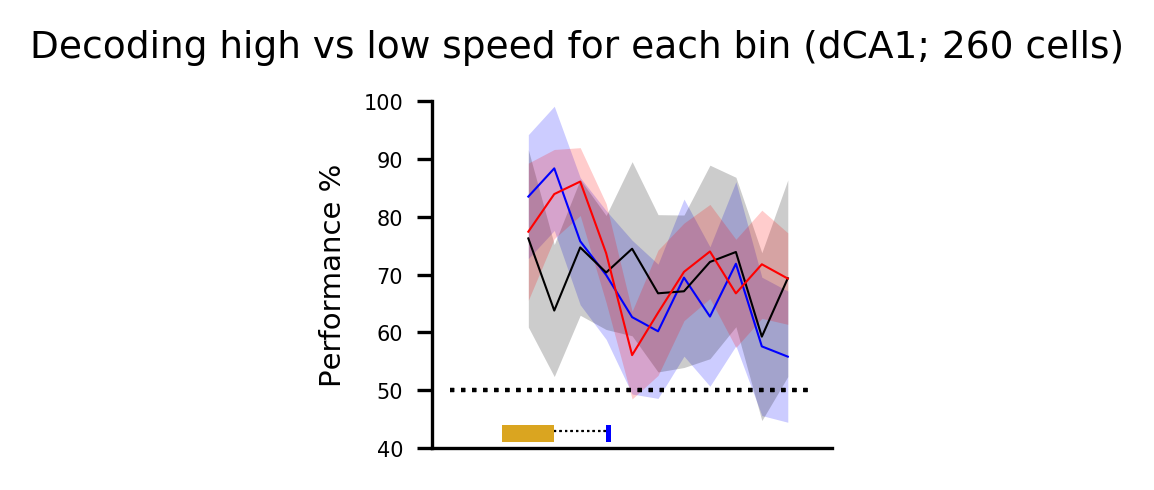

In [435]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for comp,c in zip(speed_comparisons[4:],['b','k','r']):
    try:
            ax.plot([(t-2) for t in range(3,14)], [(np.mean(eval("late_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100) for t in range(3,14)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1)
#                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("late_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100) for t in range(3,14)])
            s = np.array([np.std(eval("late_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100 for t in range(3,14)])
            ax.fill_between([(t-2) for t in range(3,14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
    except:
            continue
    ax.set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax.hlines(50, -2,bin_ranges[1]-2, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax.set_ylabel('Performance %')
    pt.plot_period_bar(ax, 41, start_end=(0, 2), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax, 41, start_end=(4, 4.2), color='b', delta_y=3)
    ax.hlines(41+2, 2, 4, color='k', lw=0.5, linestyles='dotted')
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding high vs low speed for each bin (dCA1; 260 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

### now include speeds that are <= for below median variable (instead of <. This likely includes a lot of 0 speed bins)

In [438]:
for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
    for t in range(14):
        exec("above_late0_speed_median_%s_post_%s = {}"%(t,tt))
        exec("below_late0_speed_median_%s_post_%s = {}"%(t,tt))
        for ani in speed_post.keys():
            exec("above_late0_speed_median_%s_post_%s[ani]=mean_late_speed_%s_post[ani]>\
                  ((np.median(np.r_[mean_late_speed_%s_post[ani]][labels_post[ani]==%d])))"%(t,tt,t,t,lab))
            exec("below_late0_speed_median_%s_post_%s[ani]=mean_late_speed_%s_post[ani]<=\
                  ((np.median(np.r_[mean_late_speed_%s_post[ani]][labels_post[ani]==%d])))"%(t,tt,t,t,lab))

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


In [439]:
import copy
for t in range(14):
    exec("late0_speed_labels_%s_post = copy.deepcopy(labels_post)"%(t))
    for lab,tt in zip (range(1,8),['still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA']):
        for ani in late_speed_labels_post.keys():
            for i, label in enumerate(eval("late0_speed_labels_%s_post[ani]"%(t))):
                if label==lab and eval("below_late0_speed_median_%s_post_%s[ani][i]==True"%(t,tt)):
                    exec("late0_speed_labels_%s_post[ani][i]=lab*10"%(t))
                if label==lab and eval("above_late0_speed_median_%s_post_%s[ani][i]==True"%(t,tt)):
                    exec("late0_speed_labels_%s_post[ani][i]=lab*100"%(t))

In [440]:
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    for t in range(14):
        print comp,t
        try:
            exec("late0_speed_%s_not_run_%s,late0_speed_%s_total_cells_%s = Not_Run(patterns_1s_post_%s,late0_speed_labels_%s_post,classes=cl, n_cells=None,\
                  relabel=None)"%(t,comp,t,comp,t,t))
            print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",speed_not_run
            print "total cells =",eval("late0_speed_total_cells_%s"%(comp))
        except:
            print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
    
        for key in late0_speed_labels_post.keys():
            v0=0
            v1=0
            for val in eval("late0_speed_labels_%s_post[key]"%(t)):
                if val == cl[0]:
                    v0 += 1
                if val == cl[1]:
                    v1 += 1
            print v0,v1
            exec("vals_%s = min(v0,v1)"%key)
            print "animal %s="%key,eval("vals_%s"%key),"min trials"
        sum_vals=0
        for key in late0_speed_labels_post.keys():
            if eval("vals_%s"%key)>=5:
                sum_vals = sum_vals + eval("vals_%s"%key)
        exec("total_%s_trials_late0_speed_%s_post = sum_vals"%(comp,t))
        print "total_%s_trials_late0_speed_%s_post ="%(comp,t),eval("total_%s_trials_late0_speed_%s_post"%(comp,t)),"\n"

still_rew 0


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 395
17 8
animal dhpc40b= 8 min trials
3 1
animal dhpc37= 1 min trials
5 1
animal dNAc3= 1 min trials
20 5
animal dhpc40= 5 min trials
5 0
animal dhpc39= 0 min trials
total_still_rew_trials_late0_speed_0_post = 13 

still_rew 1


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 395
16 9
animal dhpc40b= 9 min trials
2 2
animal dhpc37= 2 min trials
4 2
animal dNAc3= 2 min trials
22 3
animal dhpc40= 3 min trials
4 1
animal dhpc39= 1 min trials
total_still_rew_trials_late0_speed_1_post = 9 

still_rew 2


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 395
19 6
animal dhpc40b= 6 min trials
4 0
animal dhpc37= 0 min trials
6 0
animal dNAc3= 0 min trials
21 4
animal dhpc40= 4 min trials
3 2
animal dhpc39= 2 min trials
total_still_rew_trials_late0_speed_2_post = 6 

still_rew 3


NOT INCLUDED IN ANALYSIS (too few trials): []
total cells = 395
17 8
animal dhpc40b= 8 min trials
2 2
animal dhpc37= 2 mi

In [443]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=50
classes=[10,100],[20,200],[30,300],[40,400],[50,500],[60,600],[70,700]
speed_comparisons='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for cl,comp in zip(classes,speed_comparisons):
    print comp,
    for t in range(14): # number of time bins
        exec('late0_speed_scores_gmin_%s_%s = {}'%(t,comp))
        for sess in 'post',:
            try:
                eval("late0_speed_scores_gmin_%s_%s"%(t,comp))[sess] = np.r_[[do_test_within(eval("patterns_1s_%s_%s"%(sess,t)),
                    eval("late0_speed_labels_%s_%s"%(t,sess)),classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                print".",
            except:
                print 'NOPE',

still_rew . . . . . . . . . . . . . . still_CSm . . . . . . . . . . . . . . still_AA NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE not_consumed NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE NOPE consumed . . . . . . . . . . . . . . run_CSm . . . . . . . . . . . . . . run_AA . . . . . . . . . . . . . .CPU times: user 1min 15s, sys: 108 ms, total: 1min 15s
Wall time: 1min 15s



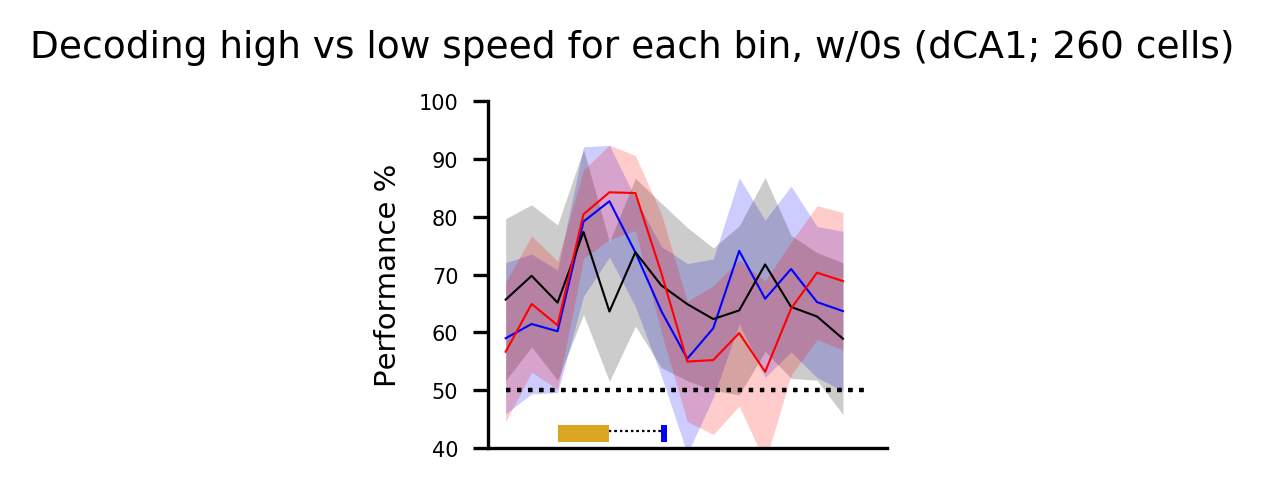

In [444]:
fig, ax = pl.subplots(1,1, figsize=(2, 1.5))

for comp,c in zip(speed_comparisons[4:],['b','k','r']):
    try:
            ax.plot([(t-2) for t in range(14)], [(np.mean(eval("late0_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100) for t in range(14)],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1)
#                       label='%sVS%s\n(trials='%(comp[0],comp[1])+str(eval("tot_trials_%s_vs_%s"%(comp[0],comp[1])))+", cells="+str(eval("total_cells_speed_%s_vs_%s"%(comp[0],comp[1])))+")")
            m = np.array([(np.mean(eval("late0_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100) for t in range(14)])
            s = np.array([np.std(eval("late0_speed_scores_gmin_%s_%s['post']"%(t,comp)))*100 for t in range(14)])
            ax.fill_between([(t-2) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
    except:
            continue
    ax.set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax.hlines(50, -2,bin_ranges[1]-2, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax.set_ylabel('Performance %')
    pt.plot_period_bar(ax, 41, start_end=(0, 2), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax, 41, start_end=(4, 4.2), color='b', delta_y=3)
    ax.hlines(41+2, 2, 4, color='k', lw=0.5, linestyles='dotted')
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding high vs low speed for each bin, w/0s (dCA1; 260 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_runVSrun_gmins_speed.jpg'%NOTEBOOK_NAME)

In [446]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'copy'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
